In [19]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import StackingClassifier

%matplotlib inline
RSEED = 42



In [20]:
df_raw = pd.read_csv('data/data/Kickstarter000.csv')
for i in range(1, 56):
    filename = 'data/data/Kickstarter0' + str(i).zfill(2) + '.csv'
    tt = pd.read_csv(filename)
    df_raw = pd.concat([df_raw, tt], axis=0)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 964
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obje

In [21]:
#df_raw.columns

In [22]:
#df_raw

In [23]:
df = df_raw[['blurb', 'category','country', 'created_at', 
       'currency','deadline', 'goal', 'id',
       'launched_at', 'location','name', 'slug',
       'source_url', 'state', 
       'urls', 'usd_pledged']] # , 'usd_type'

In [24]:
df.dropna(axis=0, inplace=True)

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
# Month of project deadline
df['month'] = pd.to_datetime(df['launched_at'], unit='s').dt.month
#df

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/3943520250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['launched_at'], unit='s').dt.month


In [26]:
# Duration the the project was online
df.eval('duration = (deadline - launched_at)/3600/24', inplace=True)
# Time between project creation and launchin
df.eval('duration_start_launch = (launched_at - created_at)/3600/24', inplace=True)
df.drop(['deadline', 'created_at', 'launched_at'], axis=1, inplace=True)
#df.head()

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
df.eval('goal_per_duration = goal / duration', inplace=True)

In [28]:
# Extract category nae
import json
df['category_name'] = df['category'].apply(lambda x : json.loads(x)['name'])
df.drop('category', axis=1, inplace=True)
#df.head()

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/4201644507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_name'] = df['category'].apply(lambda x : json.loads(x)['name'])
/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
# Get name length
df['name_length'] = df['name'].apply(lambda x : len(x.split(' ')))
df['name_upper_case'] = df['name'].apply(lambda x : sum(1 for c in x if c.isupper())/len(x))
df.drop('name', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/3788529939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name_length'] = df['name'].apply(lambda x : len(x.split(' ')))
/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/3788529939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name_upper_case'] = df['name'].apply(lambda x : sum(1 for c in x if c.isupper())/len(x))


In [30]:
df['blurb_length'] = df['blurb'].apply(lambda x : len(x.split(' ')))
df.drop('blurb', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/3027176886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blurb_length'] = df['blurb'].apply(lambda x : len(x.split(' ')))


In [31]:
# Extract city name
df['city'] = df['location'].map(lambda x : (x.split('"'))[5])
df.drop('location', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/1543756393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'] = df['location'].map(lambda x : (x.split('"'))[5])


In [32]:
df['successful'] = (df['state'] == 'successful').astype(int)
df = df[~df['state'].isin(['canceled', 'live', 'suspended'])]
df.drop('state', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_92513/1761087603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['successful'] = (df['state'] == 'successful').astype(int)


## Data cleaning
Removing duplicate rows, removing outliers, ...

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192447 entries, 0 to 964
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                192447 non-null  object 
 1   currency               192447 non-null  object 
 2   goal                   192447 non-null  float64
 3   id                     192447 non-null  int64  
 4   slug                   192447 non-null  object 
 5   source_url             192447 non-null  object 
 6   urls                   192447 non-null  object 
 7   usd_pledged            192447 non-null  float64
 8   month                  192447 non-null  int64  
 9   duration               192447 non-null  float64
 10  duration_start_launch  192447 non-null  float64
 11  goal_per_duration      192447 non-null  float64
 12  category_name          192447 non-null  object 
 13  name_length            192447 non-null  int64  
 14  name_upper_case        192447 non-null 

In [34]:
df_drop_dup = df.drop_duplicates(subset='id', keep='last')
#df_drop_dup.info()

In [35]:
df_drop_dup = df_drop_dup[df_drop_dup['name_length'] <= 20]

In [36]:
#df_drop_dup['blurb_length'].hist()
df_drop_dup = df_drop_dup[df_drop_dup['blurb_length'] <= 40]

In [37]:
#df_drop_dup['goal'].hist()
df_drop_dup = df_drop_dup[df_drop_dup['goal'] <= 10000000]

In [38]:
df_drop_dup = df_drop_dup[df_drop_dup['duration_start_launch'] <= 1000]

In [39]:
df_dummies = pd.get_dummies(df_drop_dup, columns=['country', 'currency', 'category_name', 'month'], drop_first=True)

In [40]:
features_dummies = list(df_dummies.columns)
features = list(df.columns)
for i in ['id', 'slug', 'source_url', 'urls',
        'usd_pledged', 'city']:
    features_dummies.remove(i)
    features.remove(i)

## Profile report

In [41]:
#from pandas_profiling import ProfileReport
##profile = ProfileReport(df[features], title="Pandas Profiling Report", explorative=True)
#profile

## Baseline model

## Simple Decision Tree Model

In [42]:
%run Helper_methods.ipynb    

<Figure size 576x576 with 0 Axes>

In [43]:
X = df[['name_length']]
y = np.array(df['successful'])
train, test, train_label, test_label = train_test_split(X, y, stratify=y, 
                    random_state=RSEED, test_size=0.3)

In [44]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(train, train_label)
y_pred = clf.predict(test)

accuracy_score 0.6168182211829912
f1-score 0.7424113640333002
[[ 3731 18814]
 [ 3309 31881]]
Confusion matrix, without normalization
[[ 3731 18814]
 [ 3309 31881]]


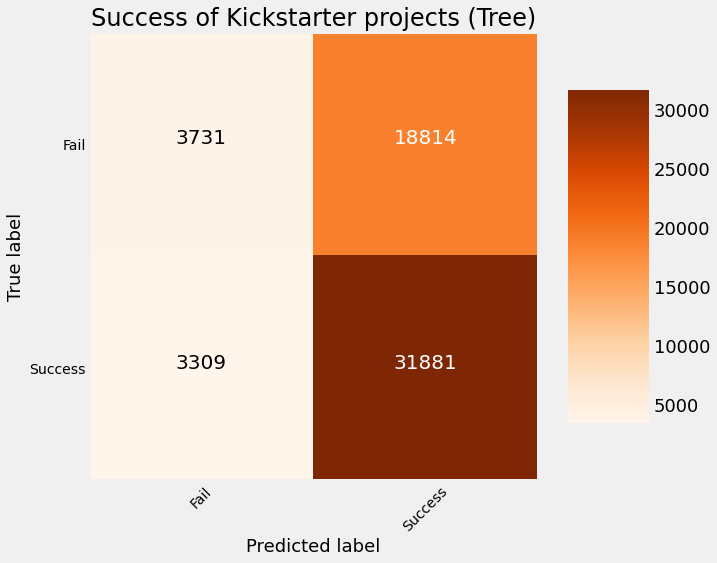

In [45]:
print('accuracy_score', accuracy_score(test_label, y_pred))
print('f1-score', f1_score(test_label, y_pred))
cm = confusion_matrix(test_label, y_pred)
print(cm)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Tree)'
)

## Plot success rate per category

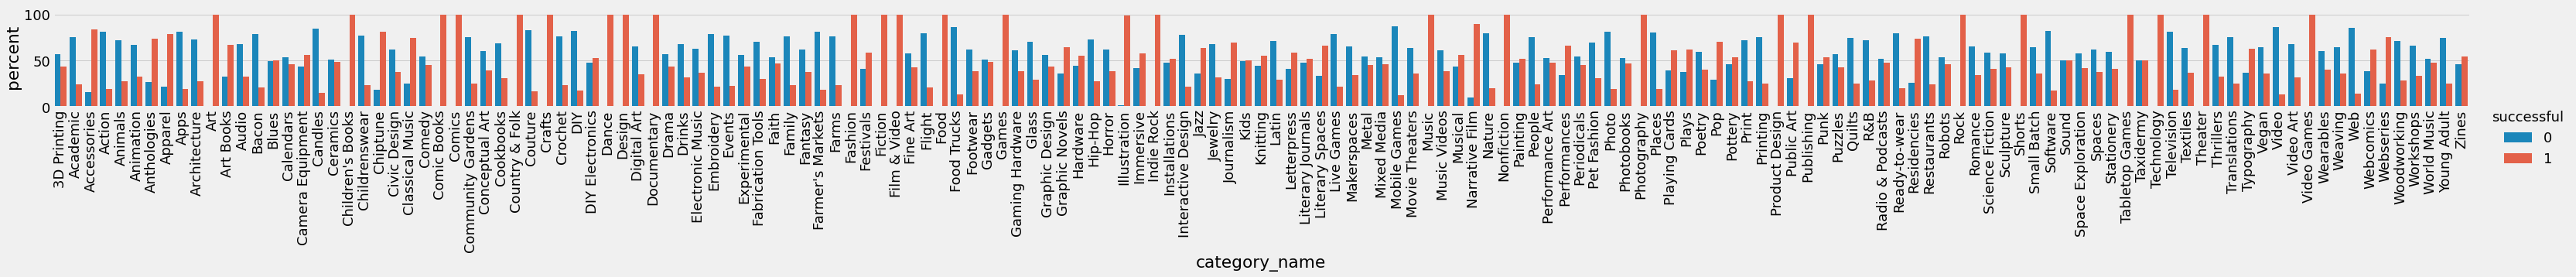

In [46]:
x,y = 'category_name', 'successful'

df1 = df_drop_dup.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()


g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=3, aspect=15)
g.ax.set_ylim(0,110)


plt.xticks(rotation=90)
plt.rcParams['figure.dpi'] = 600

## Correct imbalance

In [47]:
X = df_dummies[features_dummies].drop('successful',axis=1)
y = np.array(df_dummies['successful'])

In [48]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=RSEED)
X_over, y_over = oversample.fit_resample(X, y)
train, test, train_label, test_label = train_test_split(X_over, y_over, stratify=y_over, 
                    random_state=RSEED, test_size=0.3)

In [49]:
yy = pd.Series(y_over)
df_bal = pd.concat([X_over, yy],axis=1)
df_bal.head()

goal   duration  duration_start_launch  goal_per_duration  name_length  \
0    200.0  45.000000               4.066620           4.444444            4   
1   1000.0  30.000000               2.459491          33.333333            4   
2  20000.0  10.958785             211.789410        1825.019882            7   
3  14500.0  30.000000              45.005729         483.333333            5   
4  10000.0  31.000000              22.271551         322.580645            1   

   name_upper_case  blurb_length  country_AU  country_BE  country_CA  ...  \
0         0.190476            26           0           0           0  ...   
1         0.133333            22           0           0           0  ...   
2         0.111111            22           0           0           0  ...   
3         0.125000            17           0           0           0  ...   
4         1.000000             9           0           0           0  ...   

   month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
0        0        0        0        0        0        0         0         0   
1        0        0        0        0        0        0         0         0   
2        0        0        0        0        0        0         0         1   
3        0        0        0        0        0        1         0         0   
4        0        0        1        0        0        0         0         0   

   month_12  0  
0         1  1  
1         0  0  
2         0  0  
3         0  0  
4         0  0  

[5 rows x 211 columns]

<AxesSubplot:>

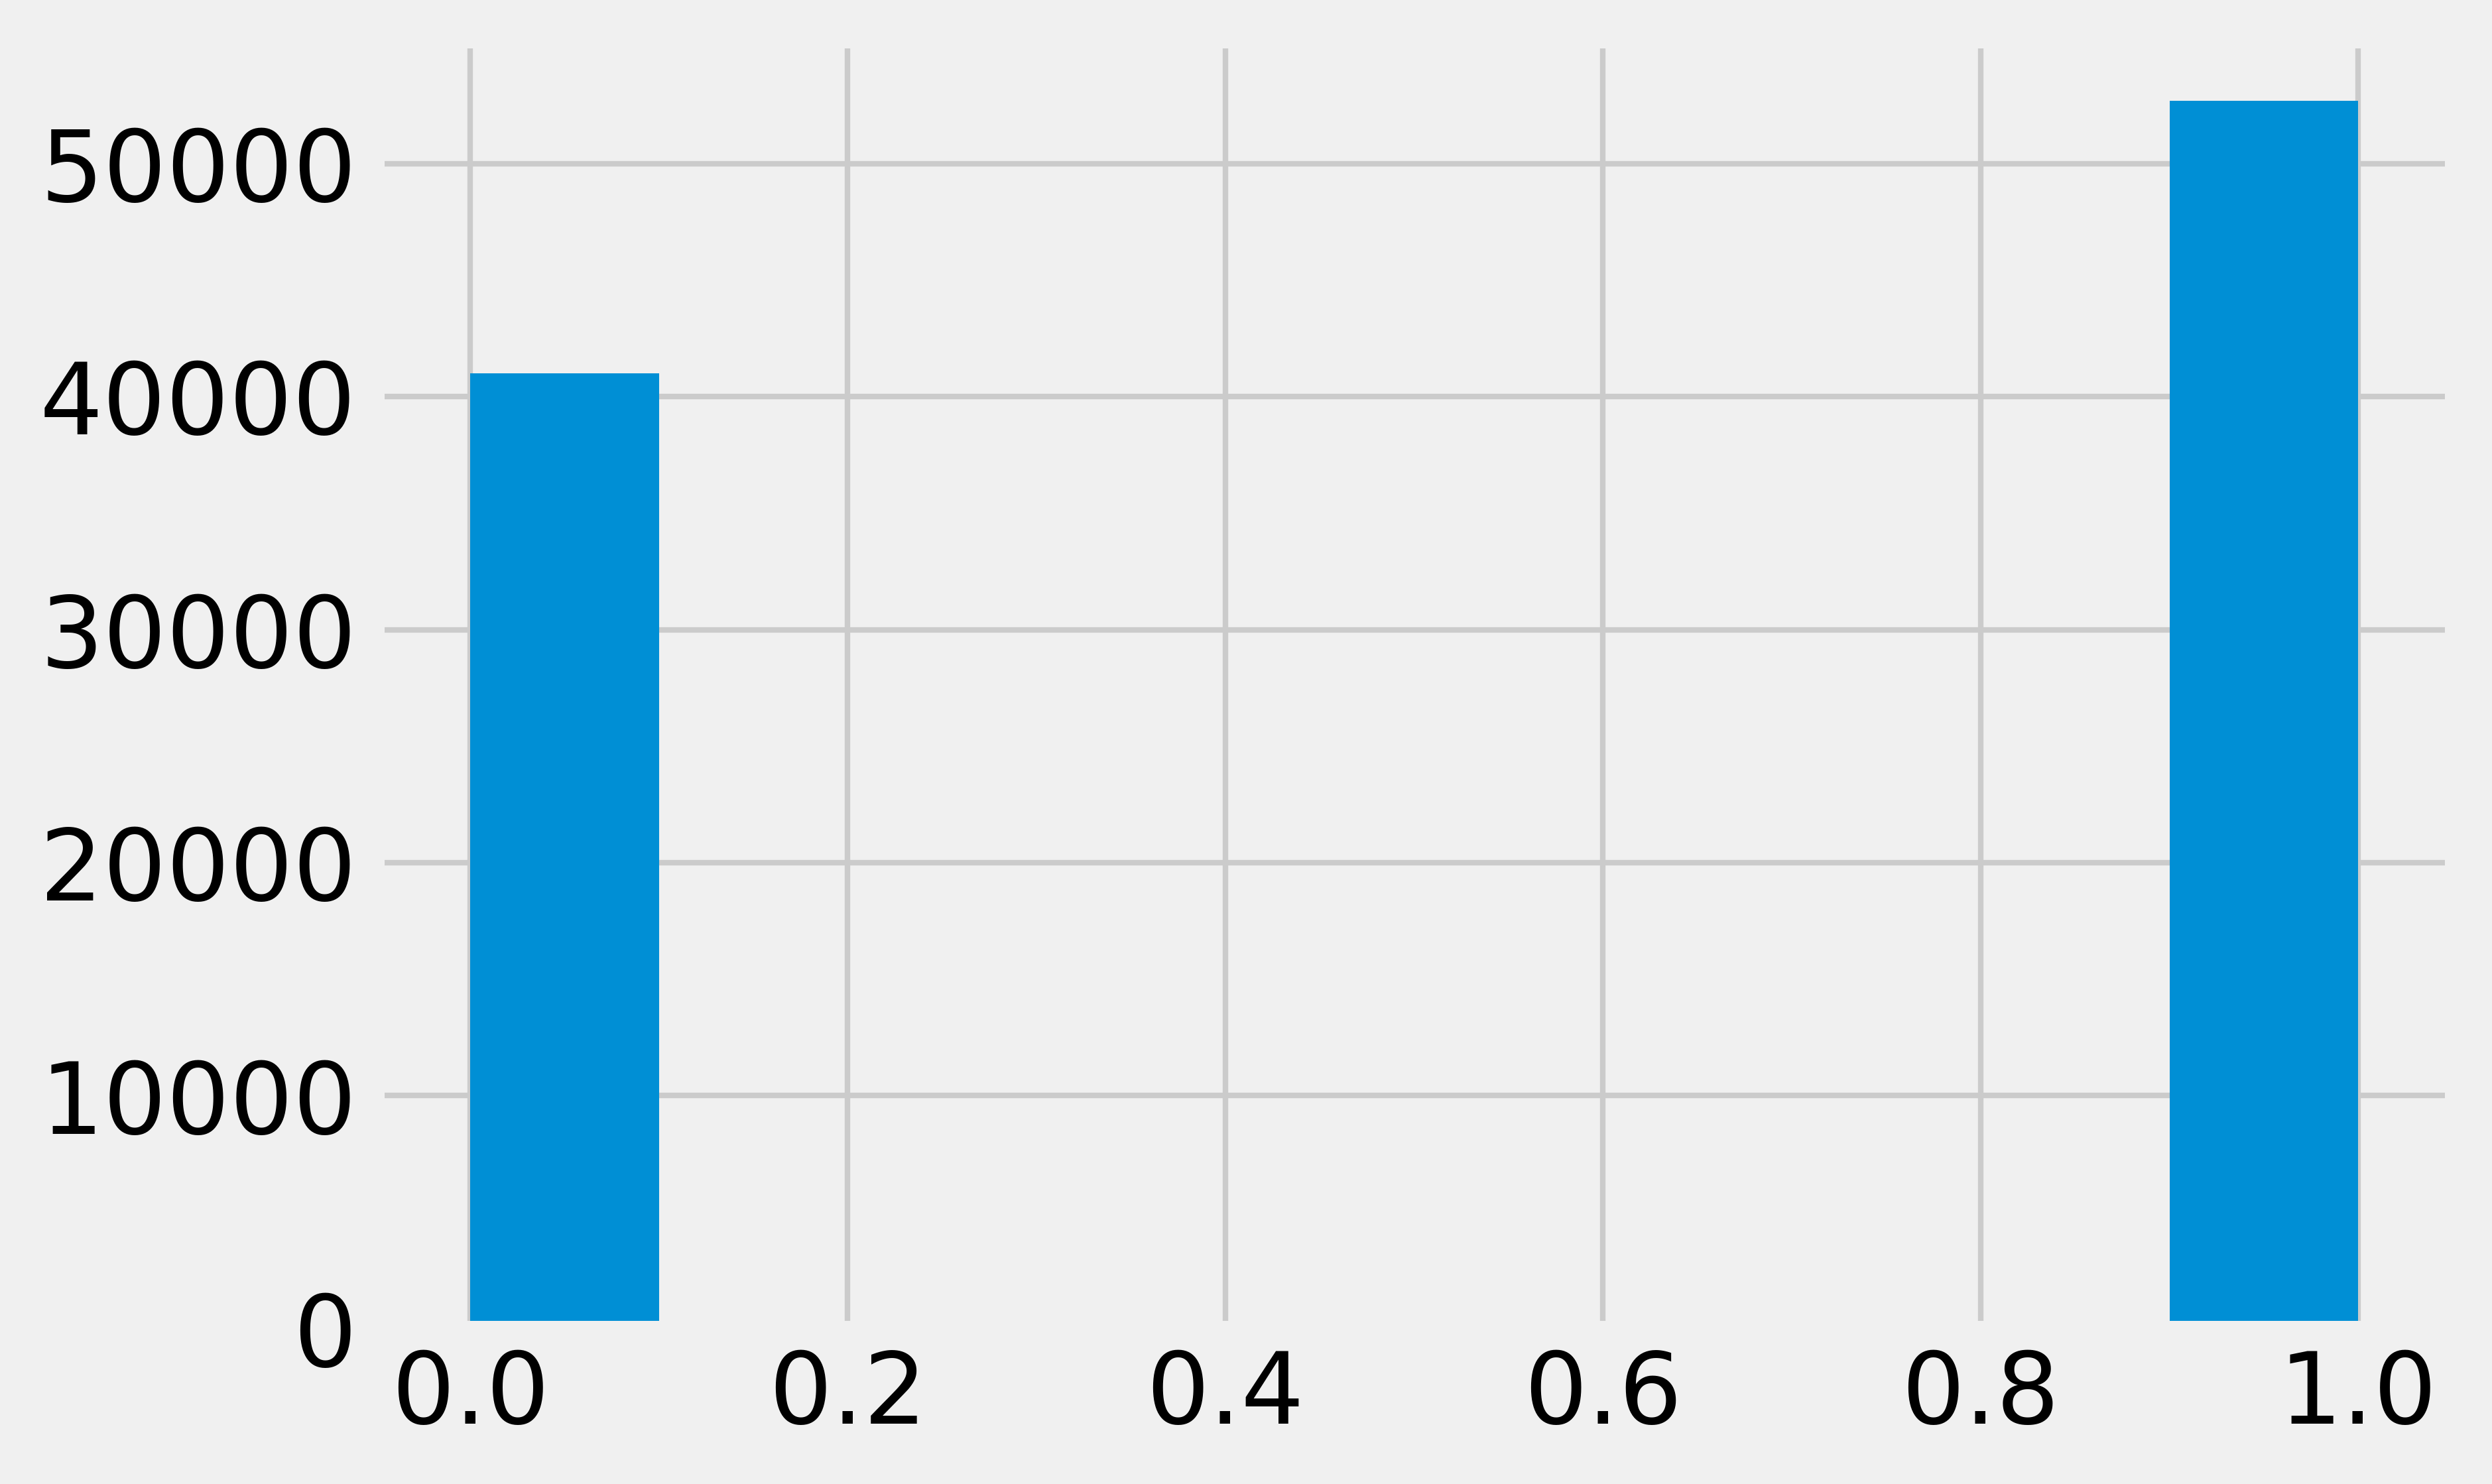

In [50]:
df_bal[df_bal['name_length'] > 5][0].hist()

<function matplotlib.pyplot.show(close=None, block=None)>

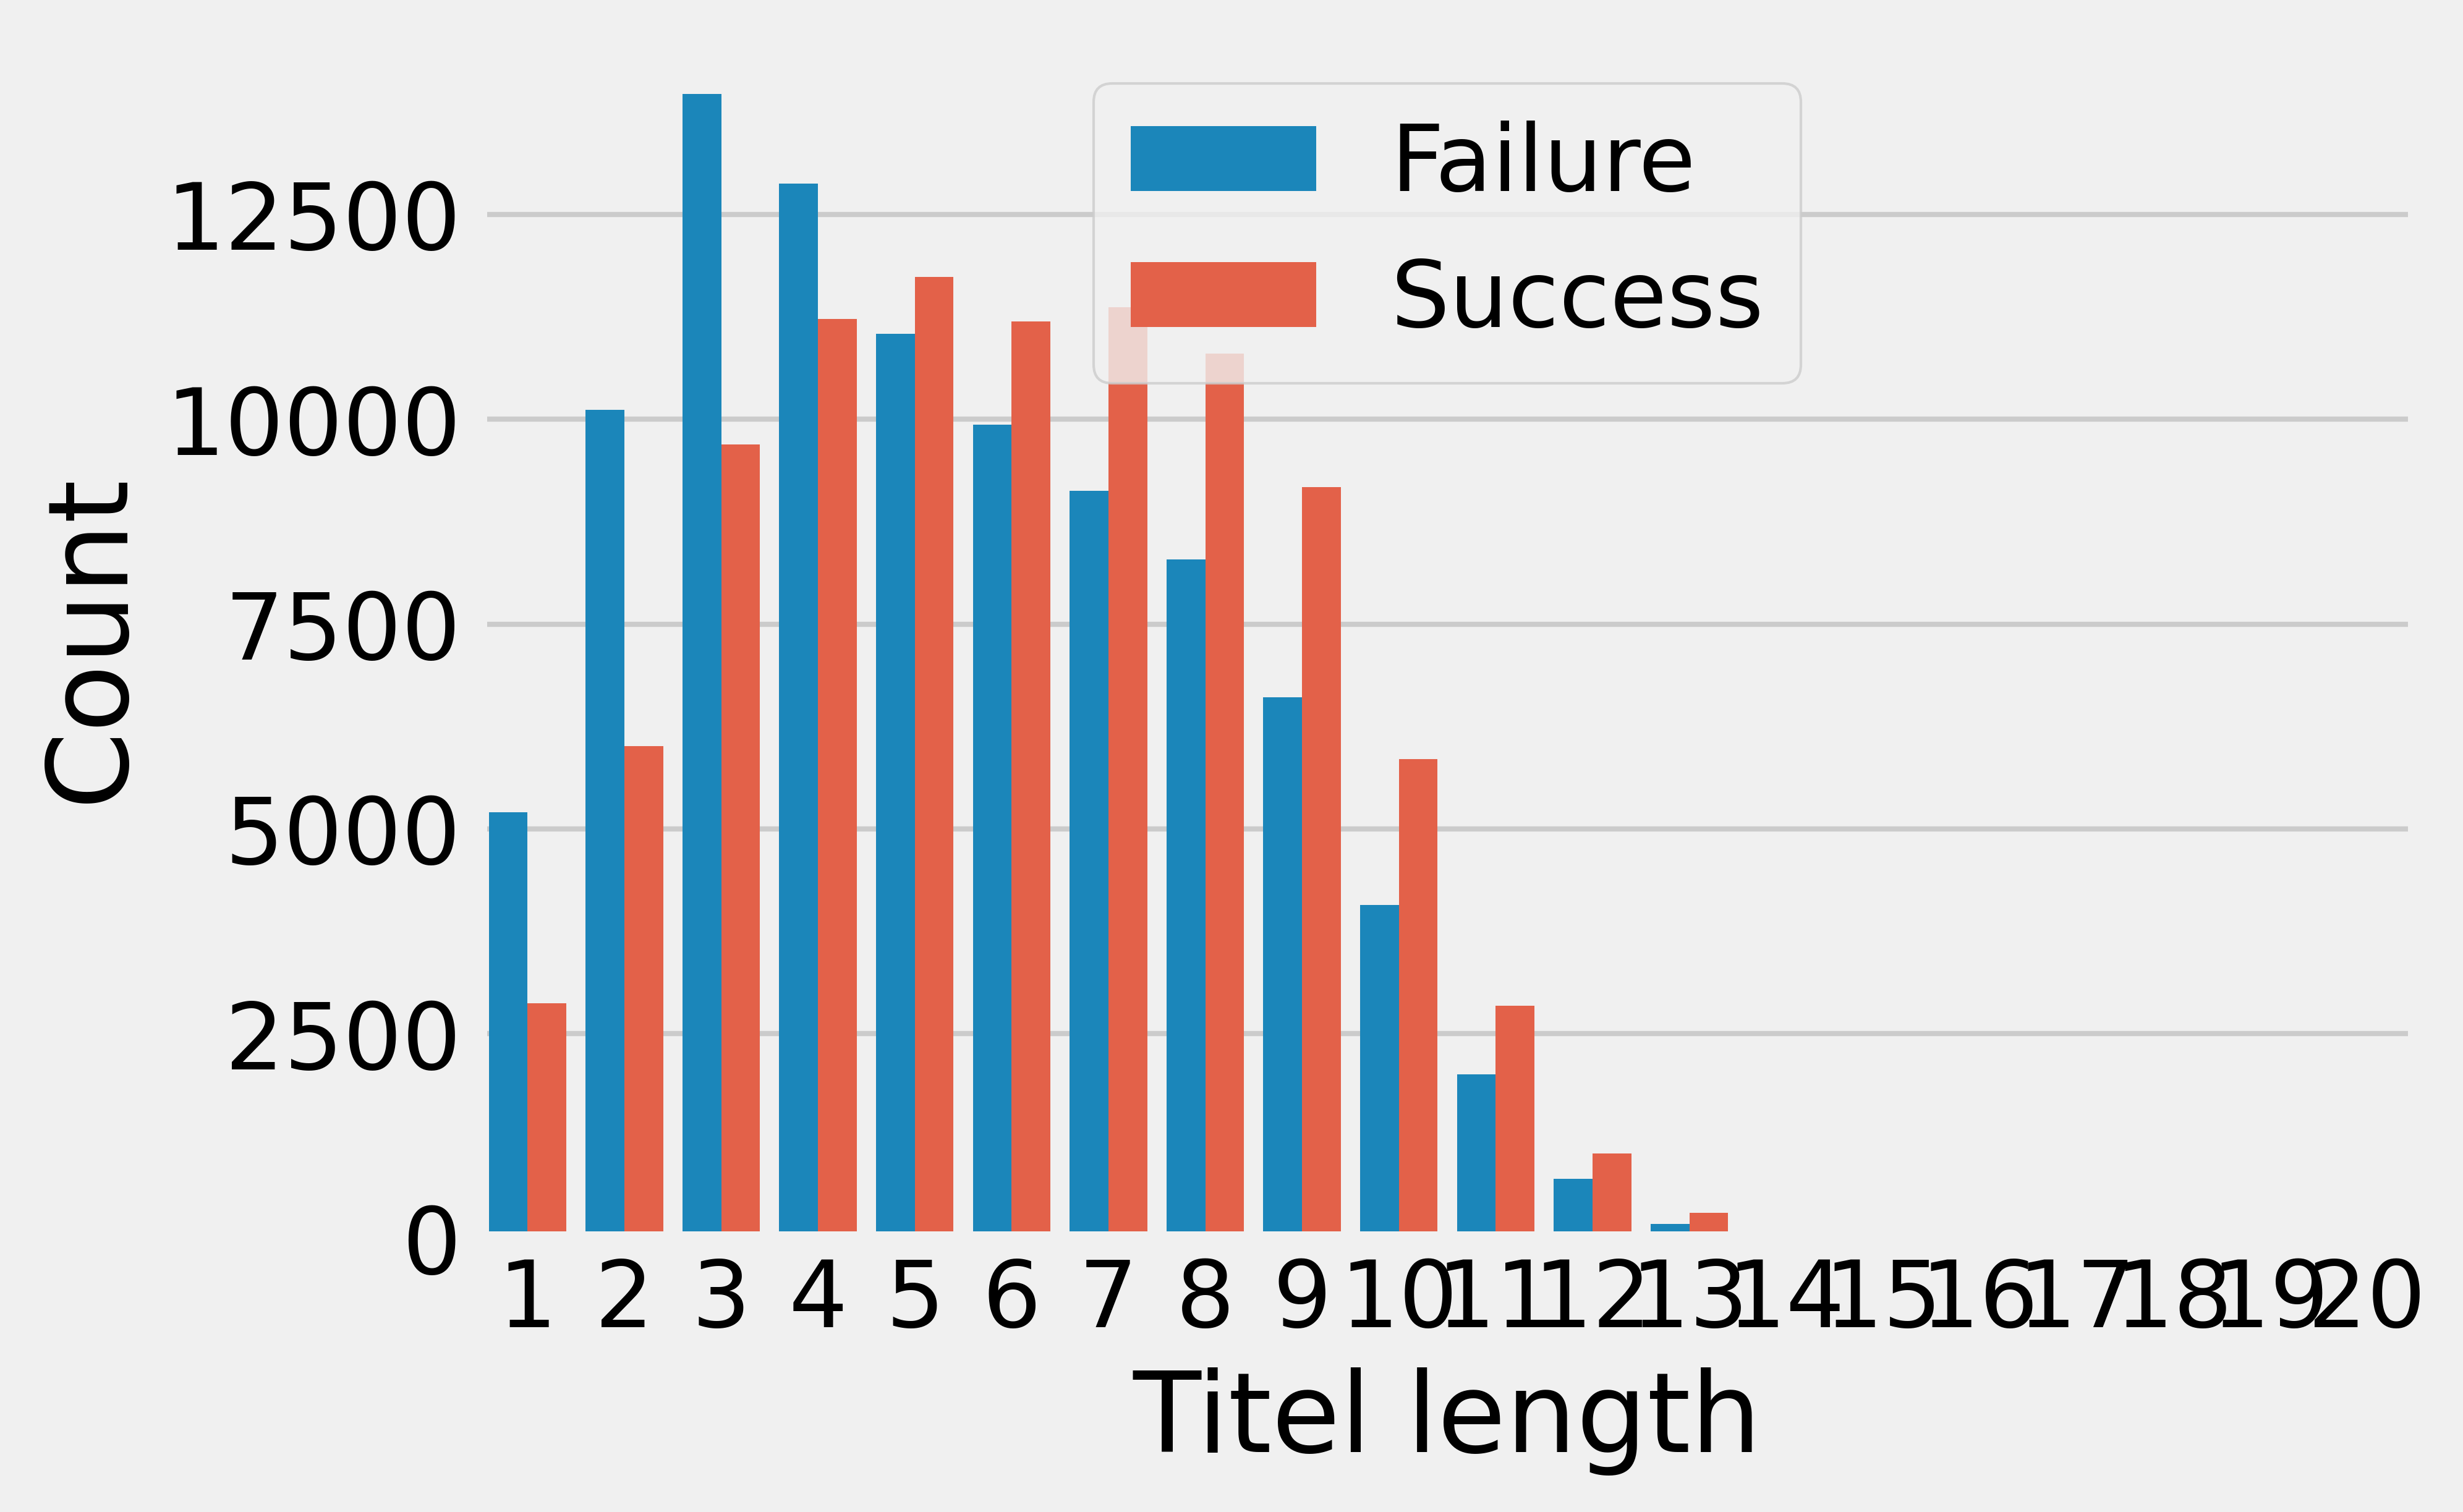

In [51]:
ax = sns.countplot(data=df_bal, x="name_length", hue=0)
ax.set(xlabel= 'Titel length', ylabel='Count')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Failure','Success'])#, bbox_to_anchor=(1,1))
plt.show

## Simple Tree model

accuracy_score 0.7732788509162952
f1-score 0.754750196130958
Confusion matrix, without normalization
[[23993  4273]
 [ 8544 19722]]


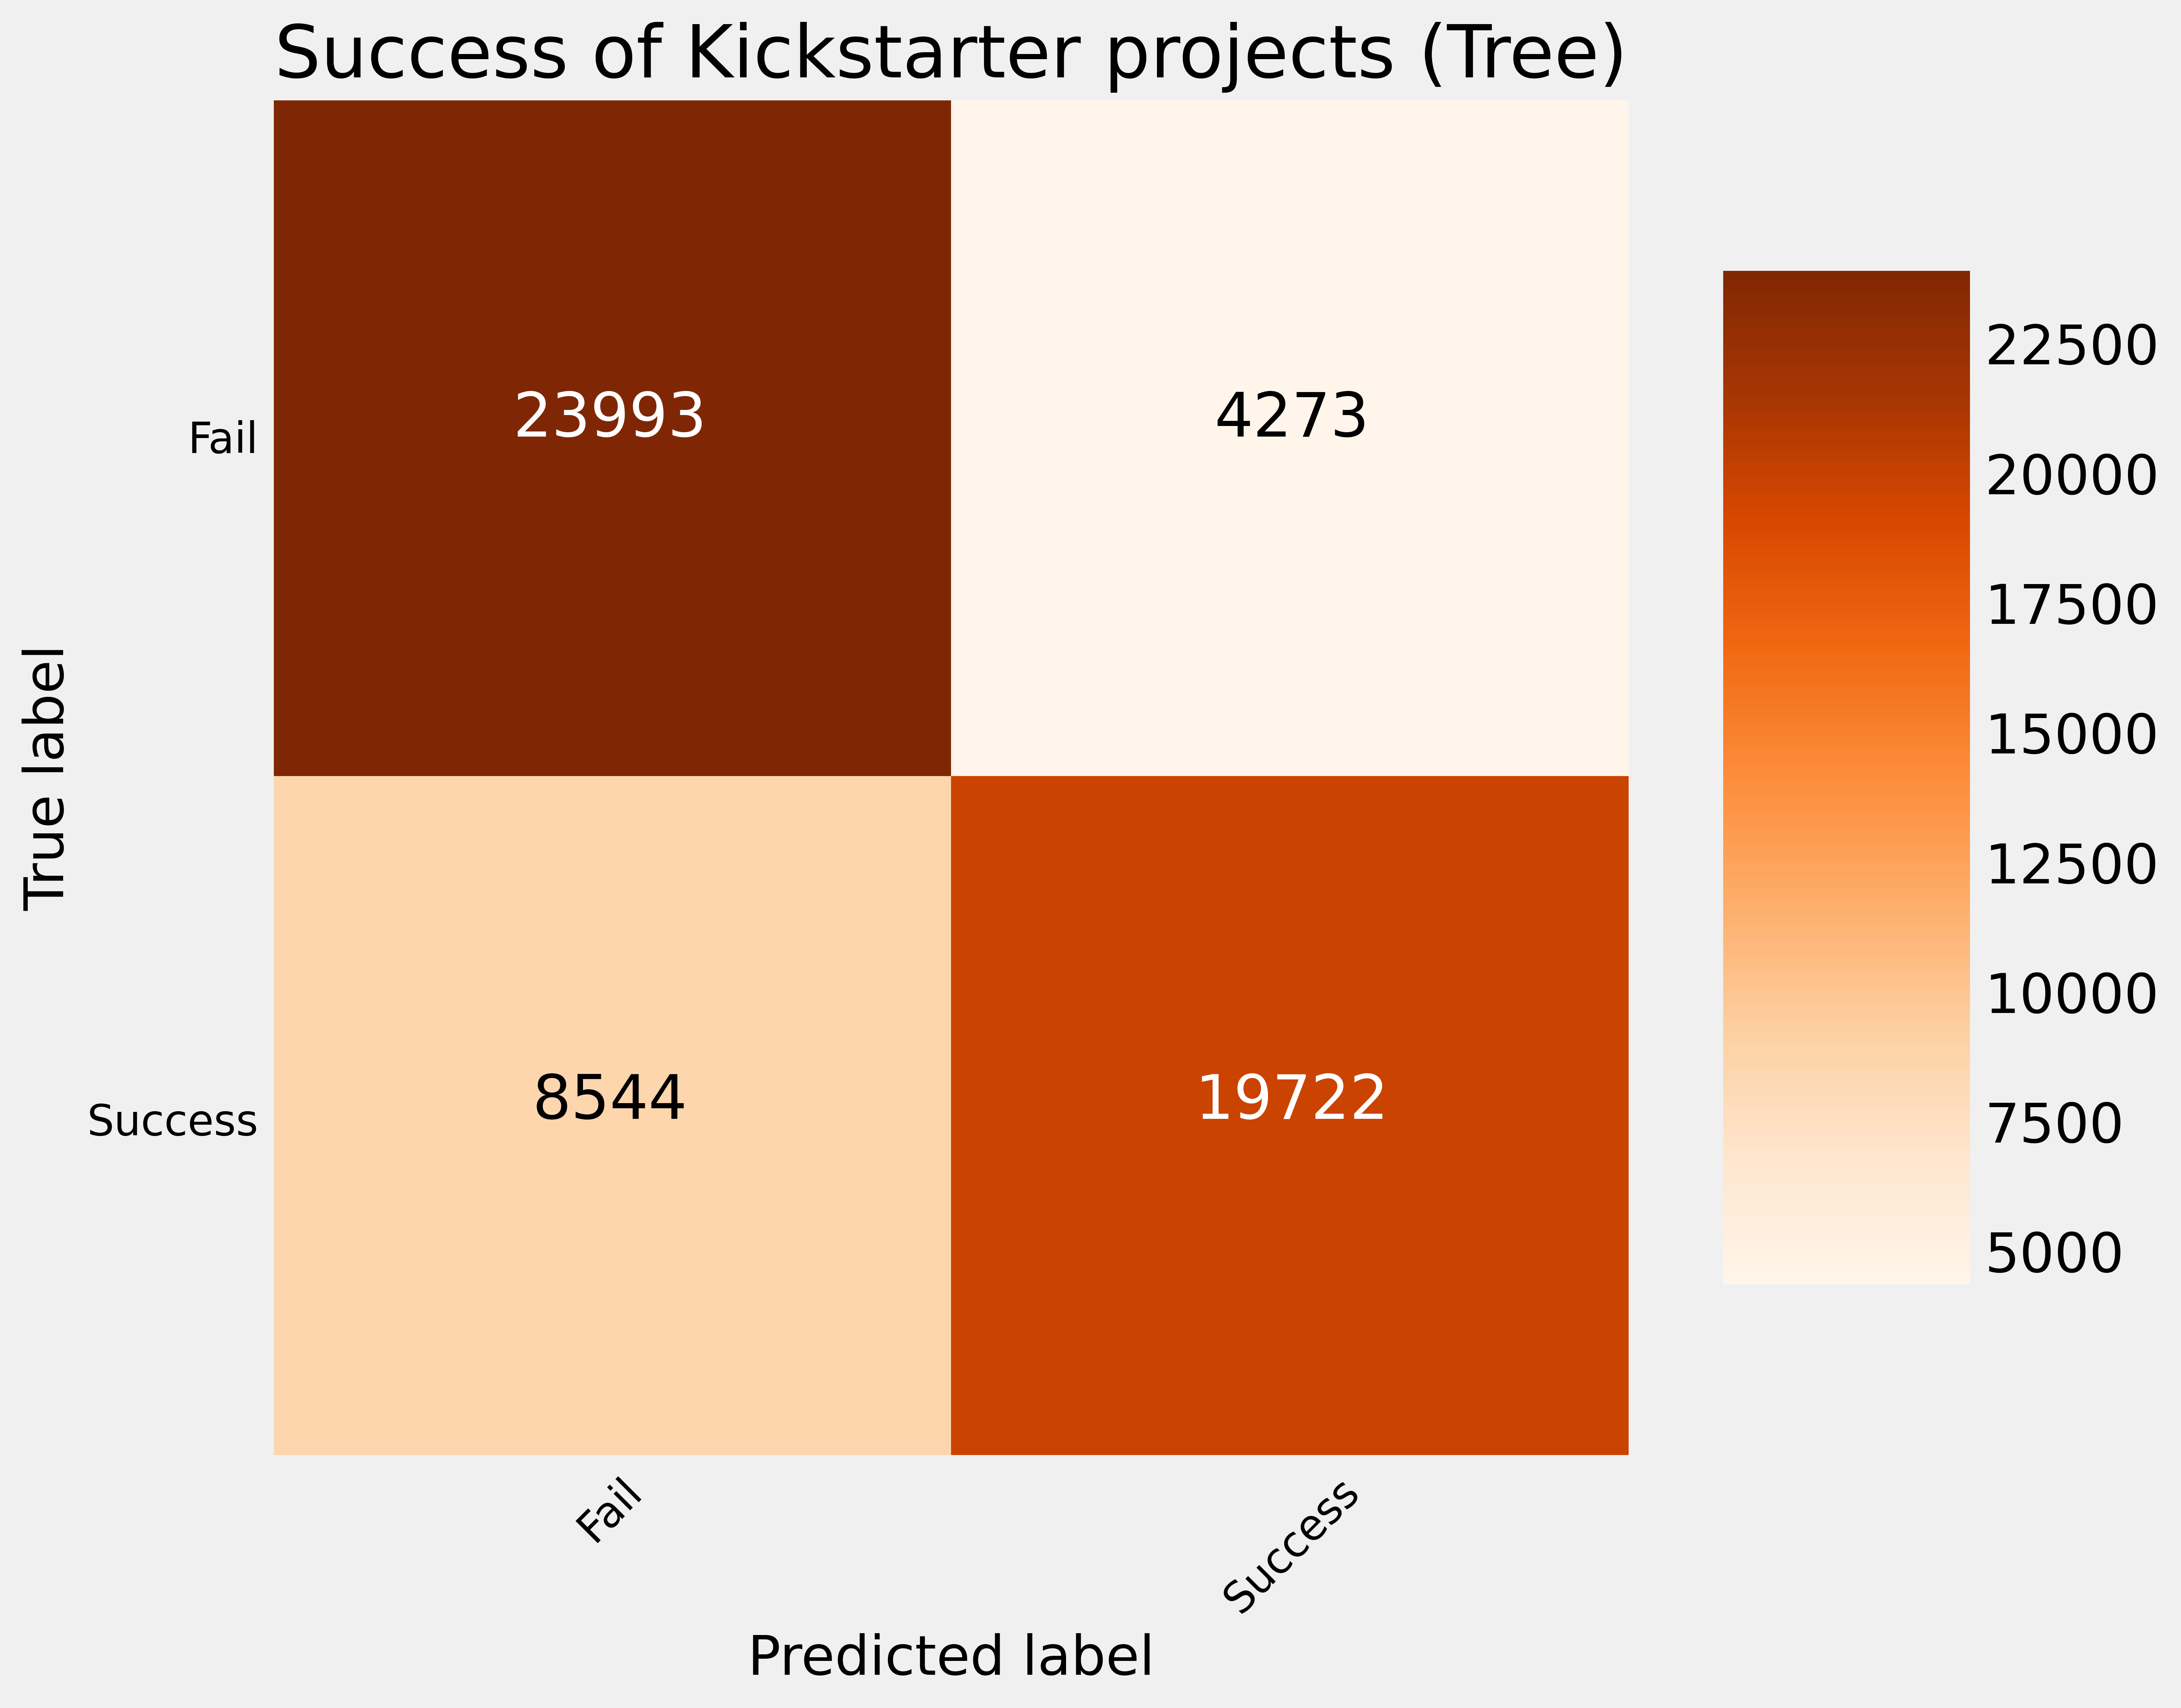

In [52]:
clf_tree = DecisionTreeClassifier()
y_pred_tree = clf_train_predict(clf_tree, train, train_label, test)
cm = simple_metrics(test_label, y_pred_tree)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Tree)'
)

Sclaing of Features

In [53]:
scaler = StandardScaler()
#scaler = MinMaxScaler
col_scale = ['goal', 'duration', 'duration_start_launch', 'name_length', 'blurb_length']
train_scaled = scaler.fit_transform(train[col_scale])
test_scaled = scaler.transform(test[col_scale])
# train = train.drop(col_scale, axis=1)
# test = test.drop(col_scale, axis=1)

train = np.concatenate([train_scaled, train.drop(col_scale, axis=1)], axis=1)
test = np.concatenate([test_scaled, test.drop(col_scale, axis=1)], axis=1)


## Trying different models

1. Random Forest 

accuracy_score 0.8236573975801316
f1-score 0.8088728694951974
Confusion matrix, without normalization
[[25468  2798]
 [ 7171 21095]]


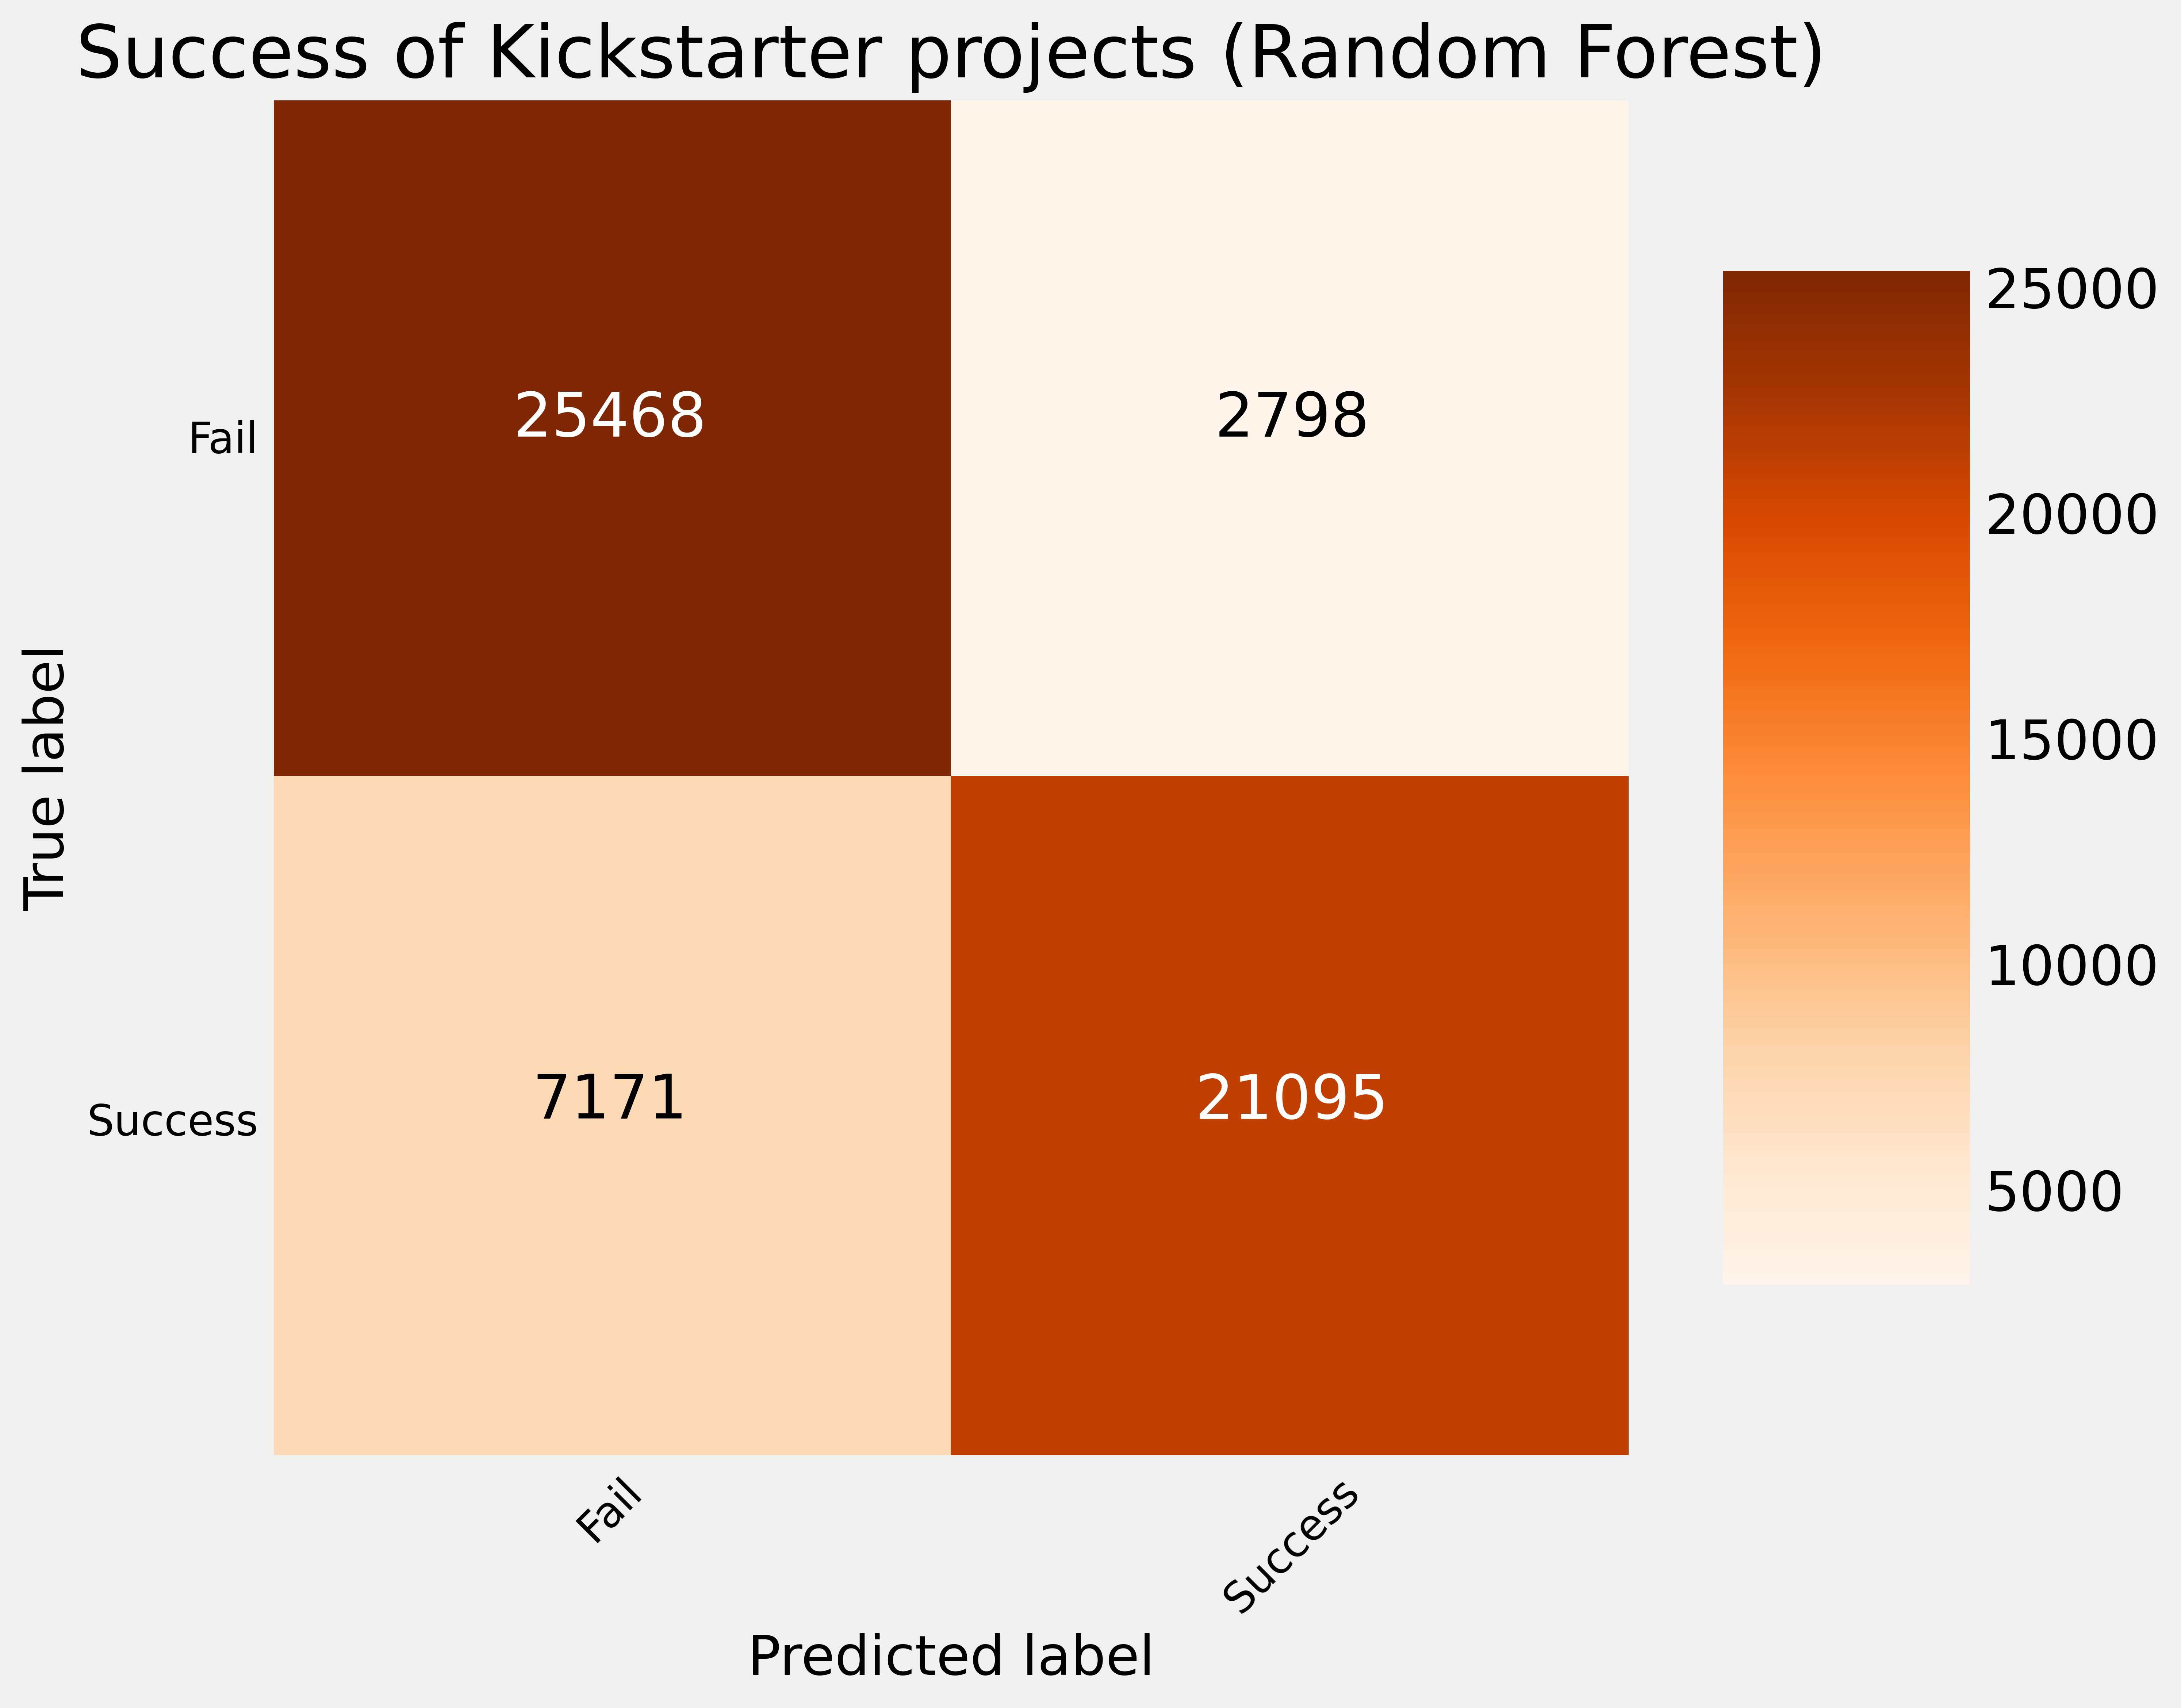

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None, 
    min_samples_split=2, 
    max_features='sqrt', 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1,
    random_state=RSEED
)
y_pred_rf = clf_train_predict(clf_rf, train, train_label, test)
cm = simple_metrics(test_label, y_pred_rf)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest)'
)

In [55]:
len(features_dummies)
type(clf_rf.feature_importances_)
rf_fi = [(x, y) for x,y in zip(features_dummies,clf_rf.feature_importances_)]
rf_fi = sorted(rf_fi, key=lambda x : x[1], reverse=True)
for i in rf_fi[0:50]:
    print(f'{i[1]}:\t{i[0]}')

#print(rf_fi)

0.10610575631252749:	duration_start_launch
0.08803206488227275:	name_upper_case
0.07724052369017005:	goal
0.06808086554197199:	duration
0.06689074144929479:	blurb_length
0.05132786210038606:	name_length
0.04880398467997574:	goal_per_duration
0.01357474436586115:	category_name_Digital Art
0.012614066571954569:	category_name_Video Art
0.011592866809341022:	category_name_Sculpture
0.011264046488911711:	category_name_Nature
0.01062572265315644:	category_name_Robots
0.010491987543706465:	category_name_Cookbooks
0.010222706328541333:	category_name_Festivals
0.010203449457043481:	category_name_Ceramics
0.00991150623167484:	category_name_Immersive
0.00978086976436188:	category_name_Comedy
0.009498208230936112:	category_name_Printing
0.009405274248767807:	category_name_Musical
0.009094126978131375:	category_name_Stationery
0.009047526434749504:	category_name_Horror
0.008882166300509246:	category_name_Weaving
0.006785065130102777:	month_6
0.006765279622038326:	month_5
0.006753078316362261:	month

2. XGBoost

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:25] WARNING: /private/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/pip-install-mi2n0a_o/xgboost_38d03cb6f6d64205821378f63f122808/build/temp.macosx-11.2-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy_score 0.7888452557843345
f1-score 0.7779782386310796
Confusion matrix, without normalization
[[23681  4585]
 [ 7352 20914]]


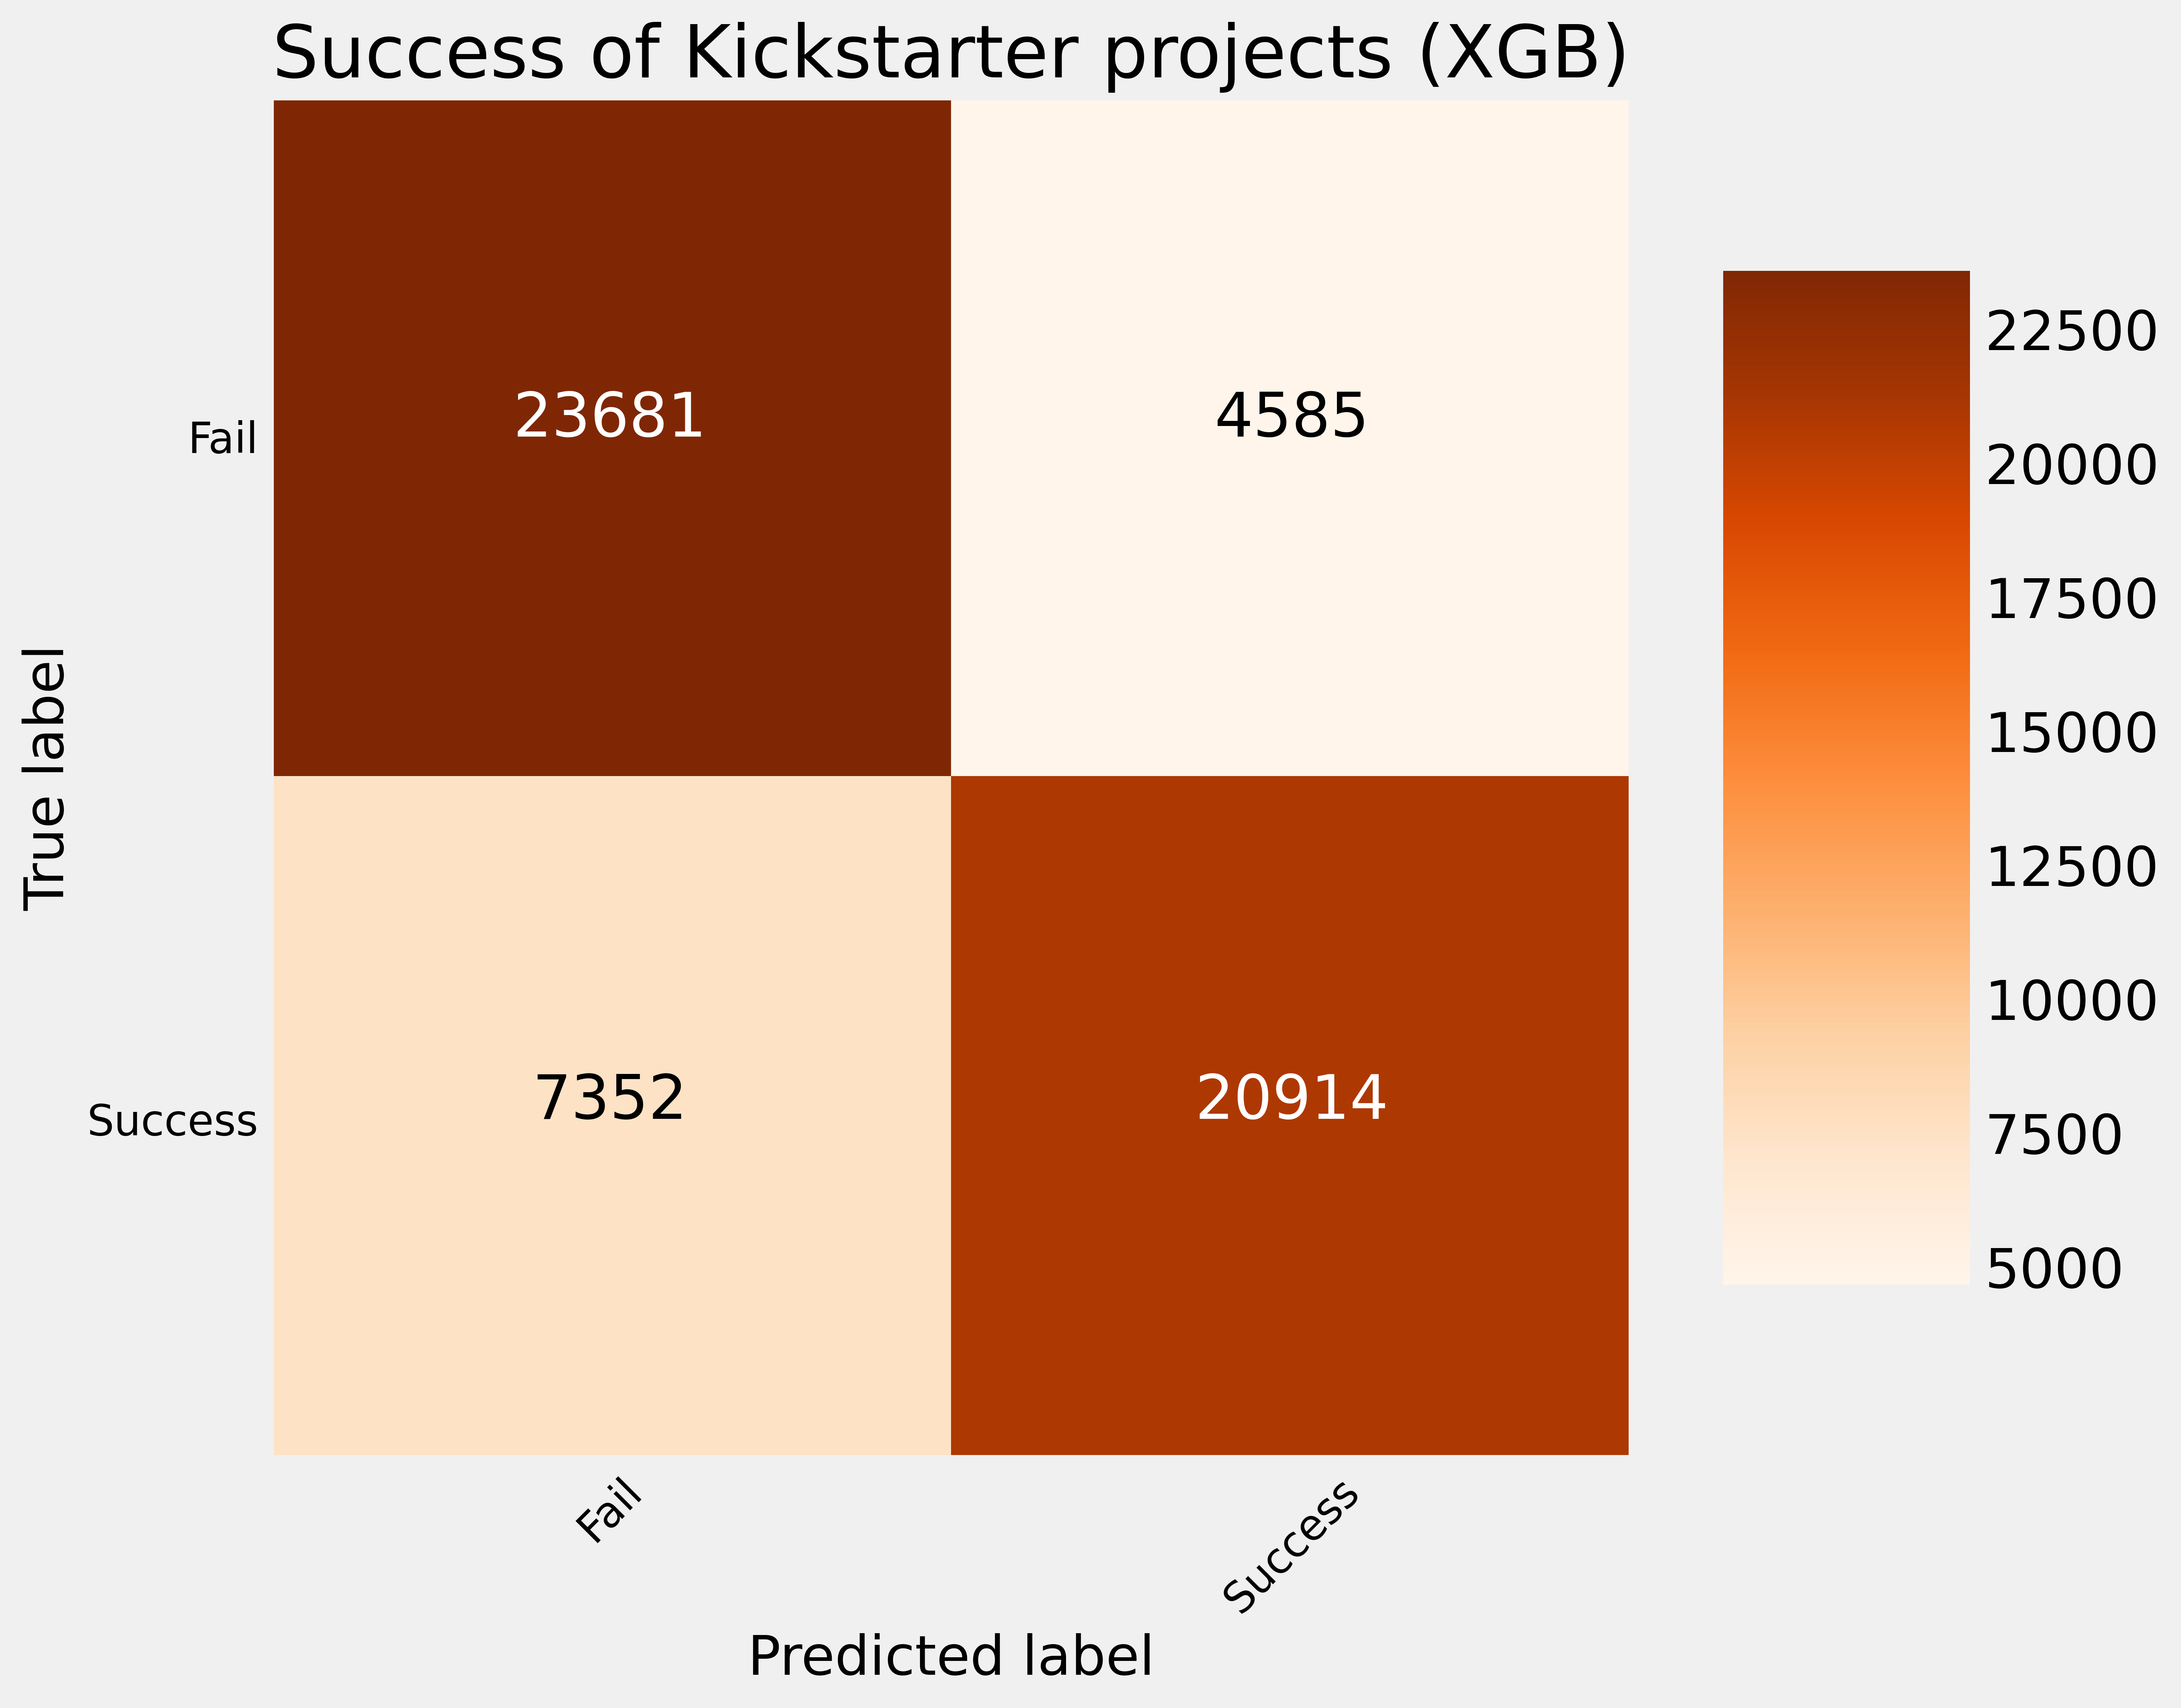

In [56]:
from xgboost import XGBClassifier 
clf_xgb = XGBClassifier( 
    n_estimators=100,
    #max_depth=20, 
    n_jobs=-1
)
y_pred_xgb = clf_train_predict(clf_xgb, train, train_label, test)
cm = simple_metrics(test_label, y_pred_xgb)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (XGB)'
)

3. Naive Bayes

accuracy_score 0.5156548503502442
f1-score 0.6726757600028691
Confusion matrix, without normalization
[[ 1016 27250]
 [  131 28135]]


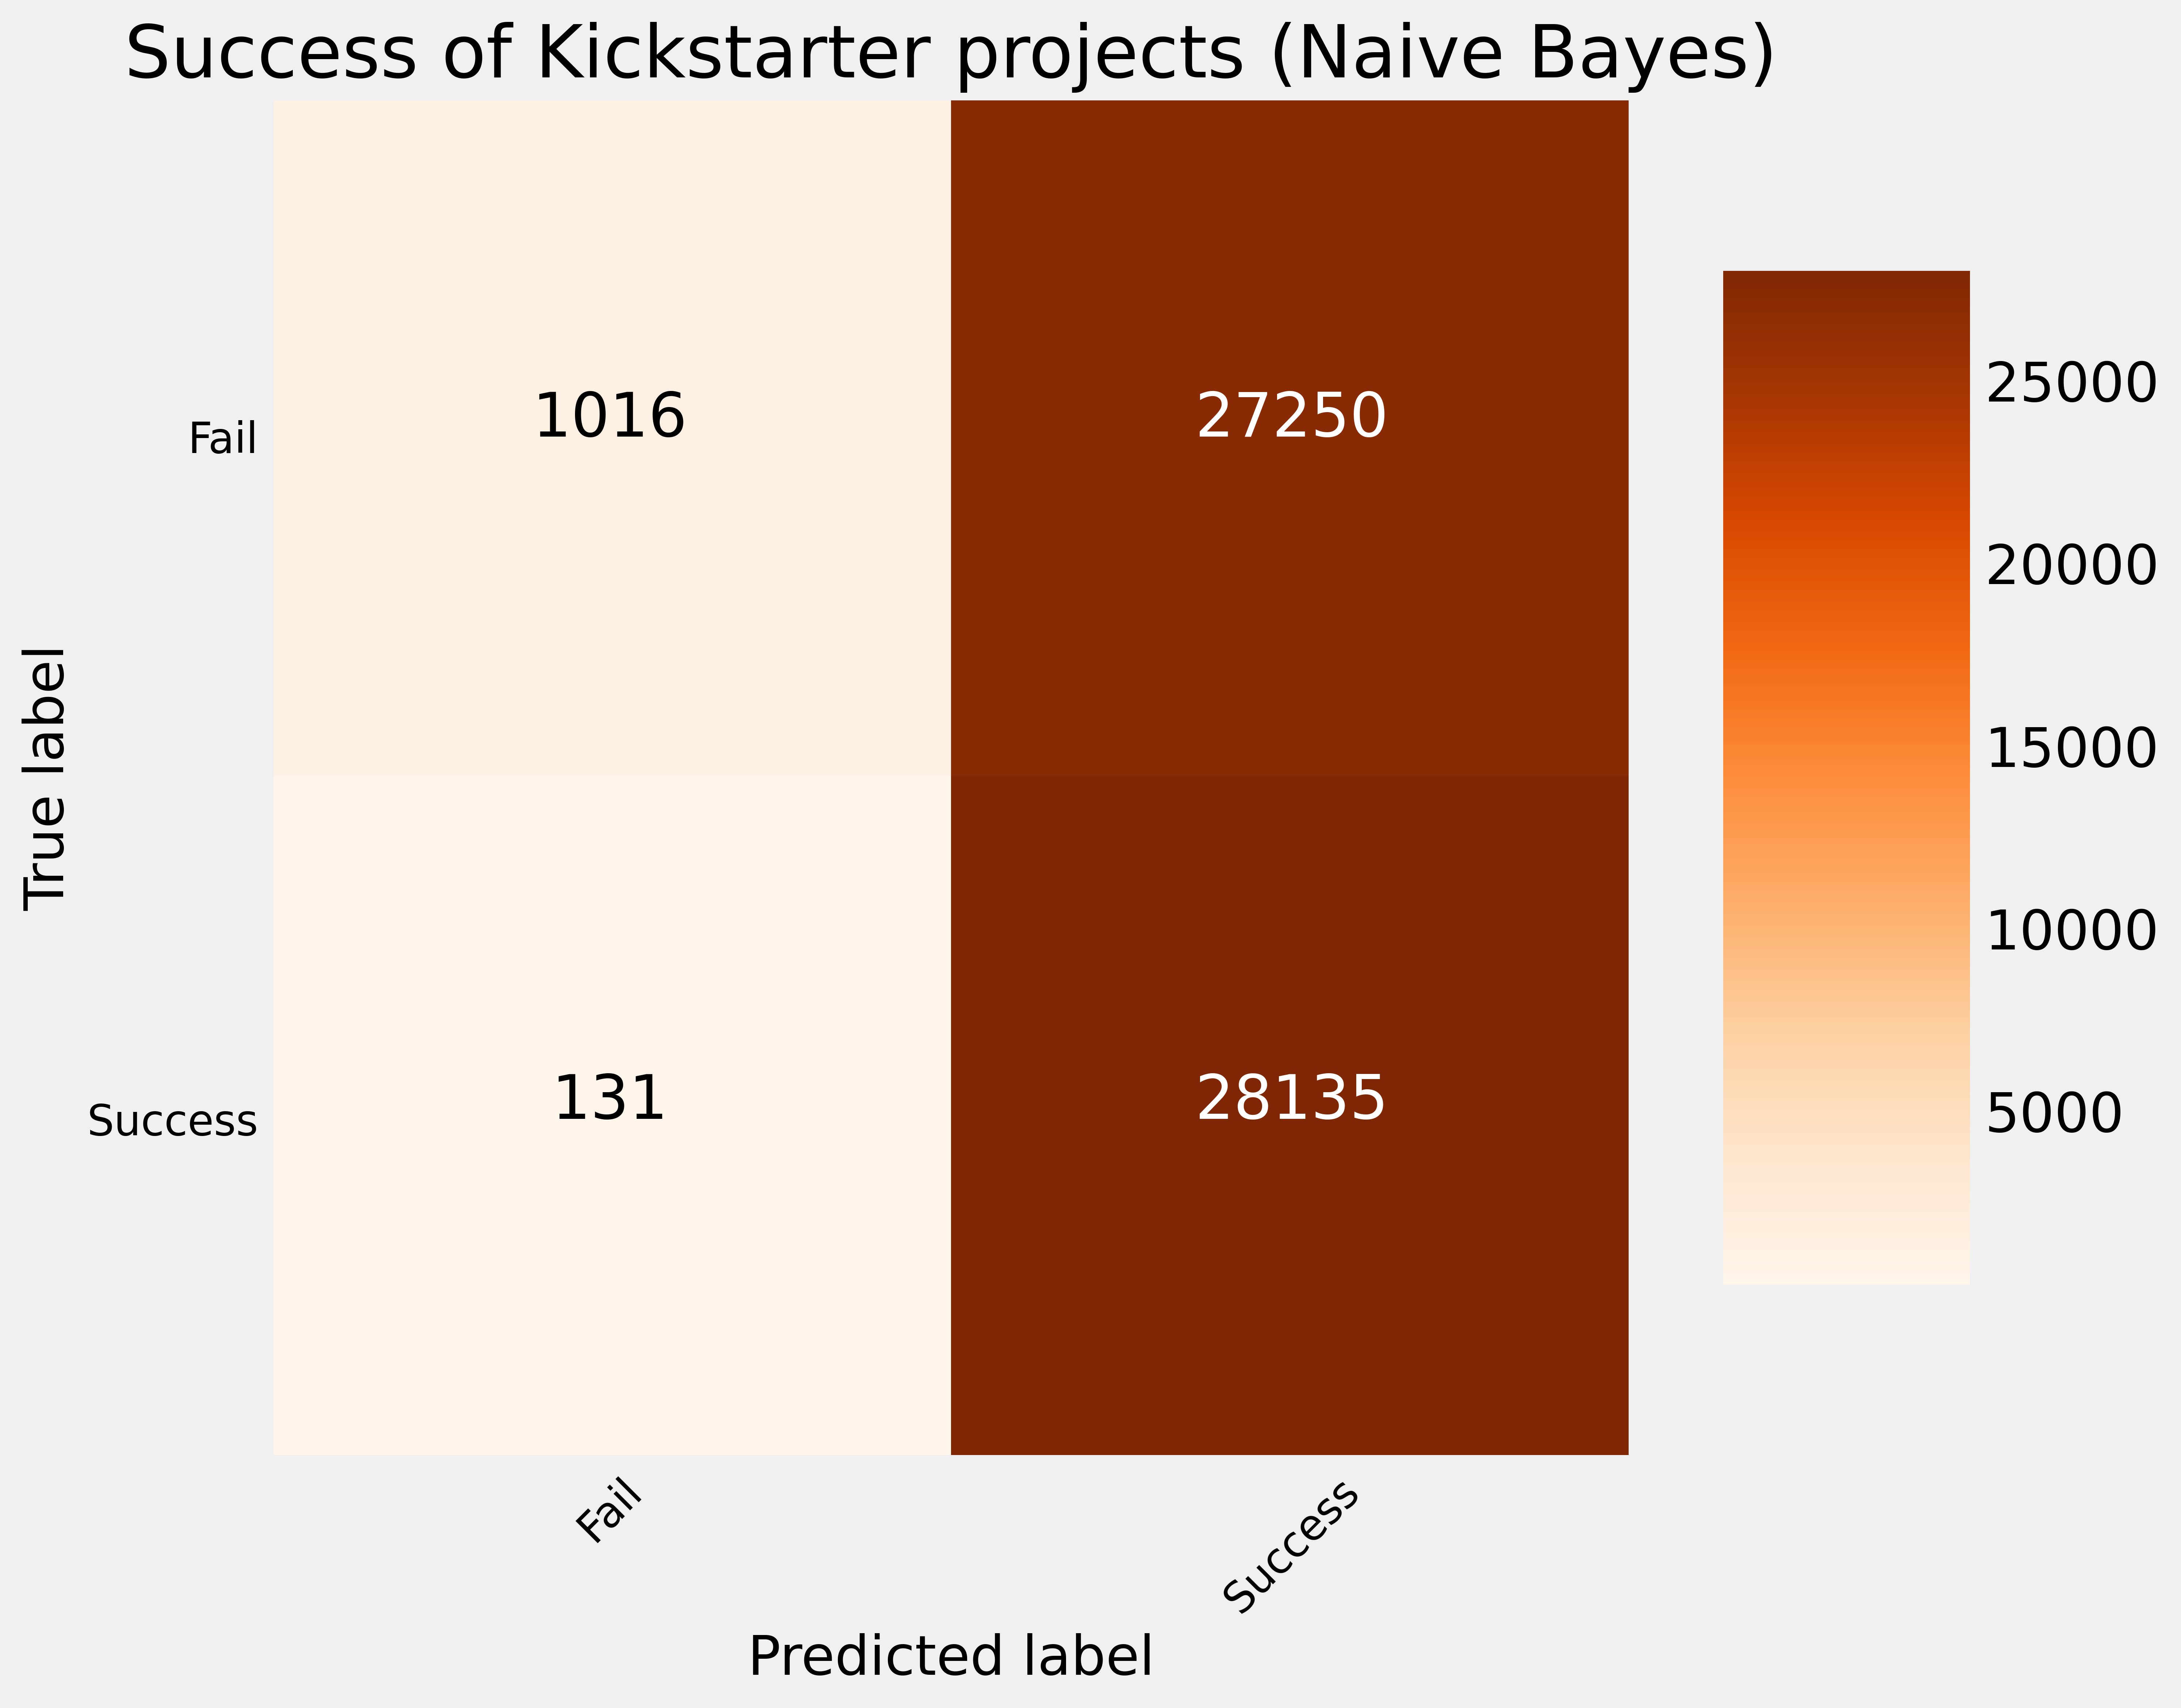

In [57]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
y_pred_gnb = clf_train_predict(clf_gnb, train, train_label, test)
cm = simple_metrics(test_label, y_pred_gnb)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Naive Bayes)'
)

4. SVM / SGDClassifier

accuracy_score 0.502671053562584
f1-score 0.01451154965123208
Confusion matrix, without normalization
[[28210    56]
 [28059   207]]


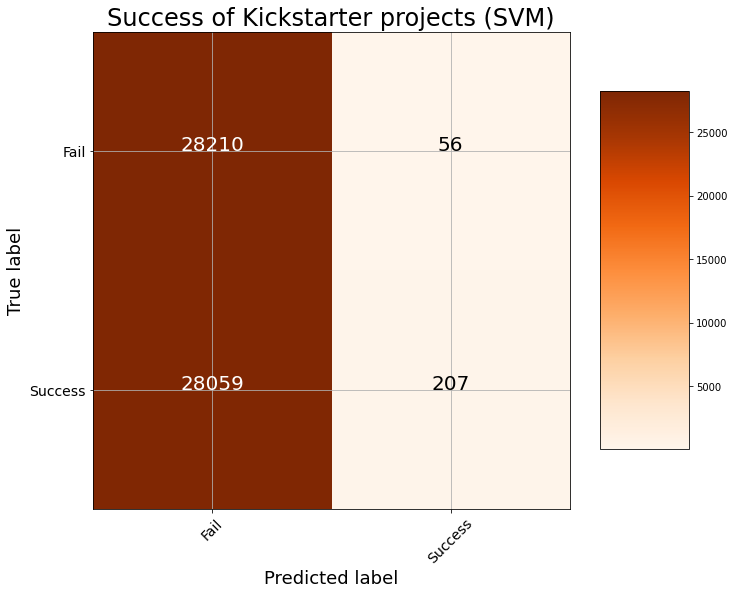

In [ ]:
#SGDClassifier (hinge = linear SVC)
from sklearn.linear_model import SGDClassifier
clf_sgd = SGDClassifier(loss='hinge')
y_pred_sgd = clf_train_predict(clf_sgd, train, train_label, test)
cm = simple_metrics(test_label, y_pred_sgd)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (SVM)'
)

Logistic Regression

accuracy_score 0.7639566970919125
f1-score 0.7447589900535577
Confusion matrix, without normalization
[[23720  4546]
 [ 8798 19468]]


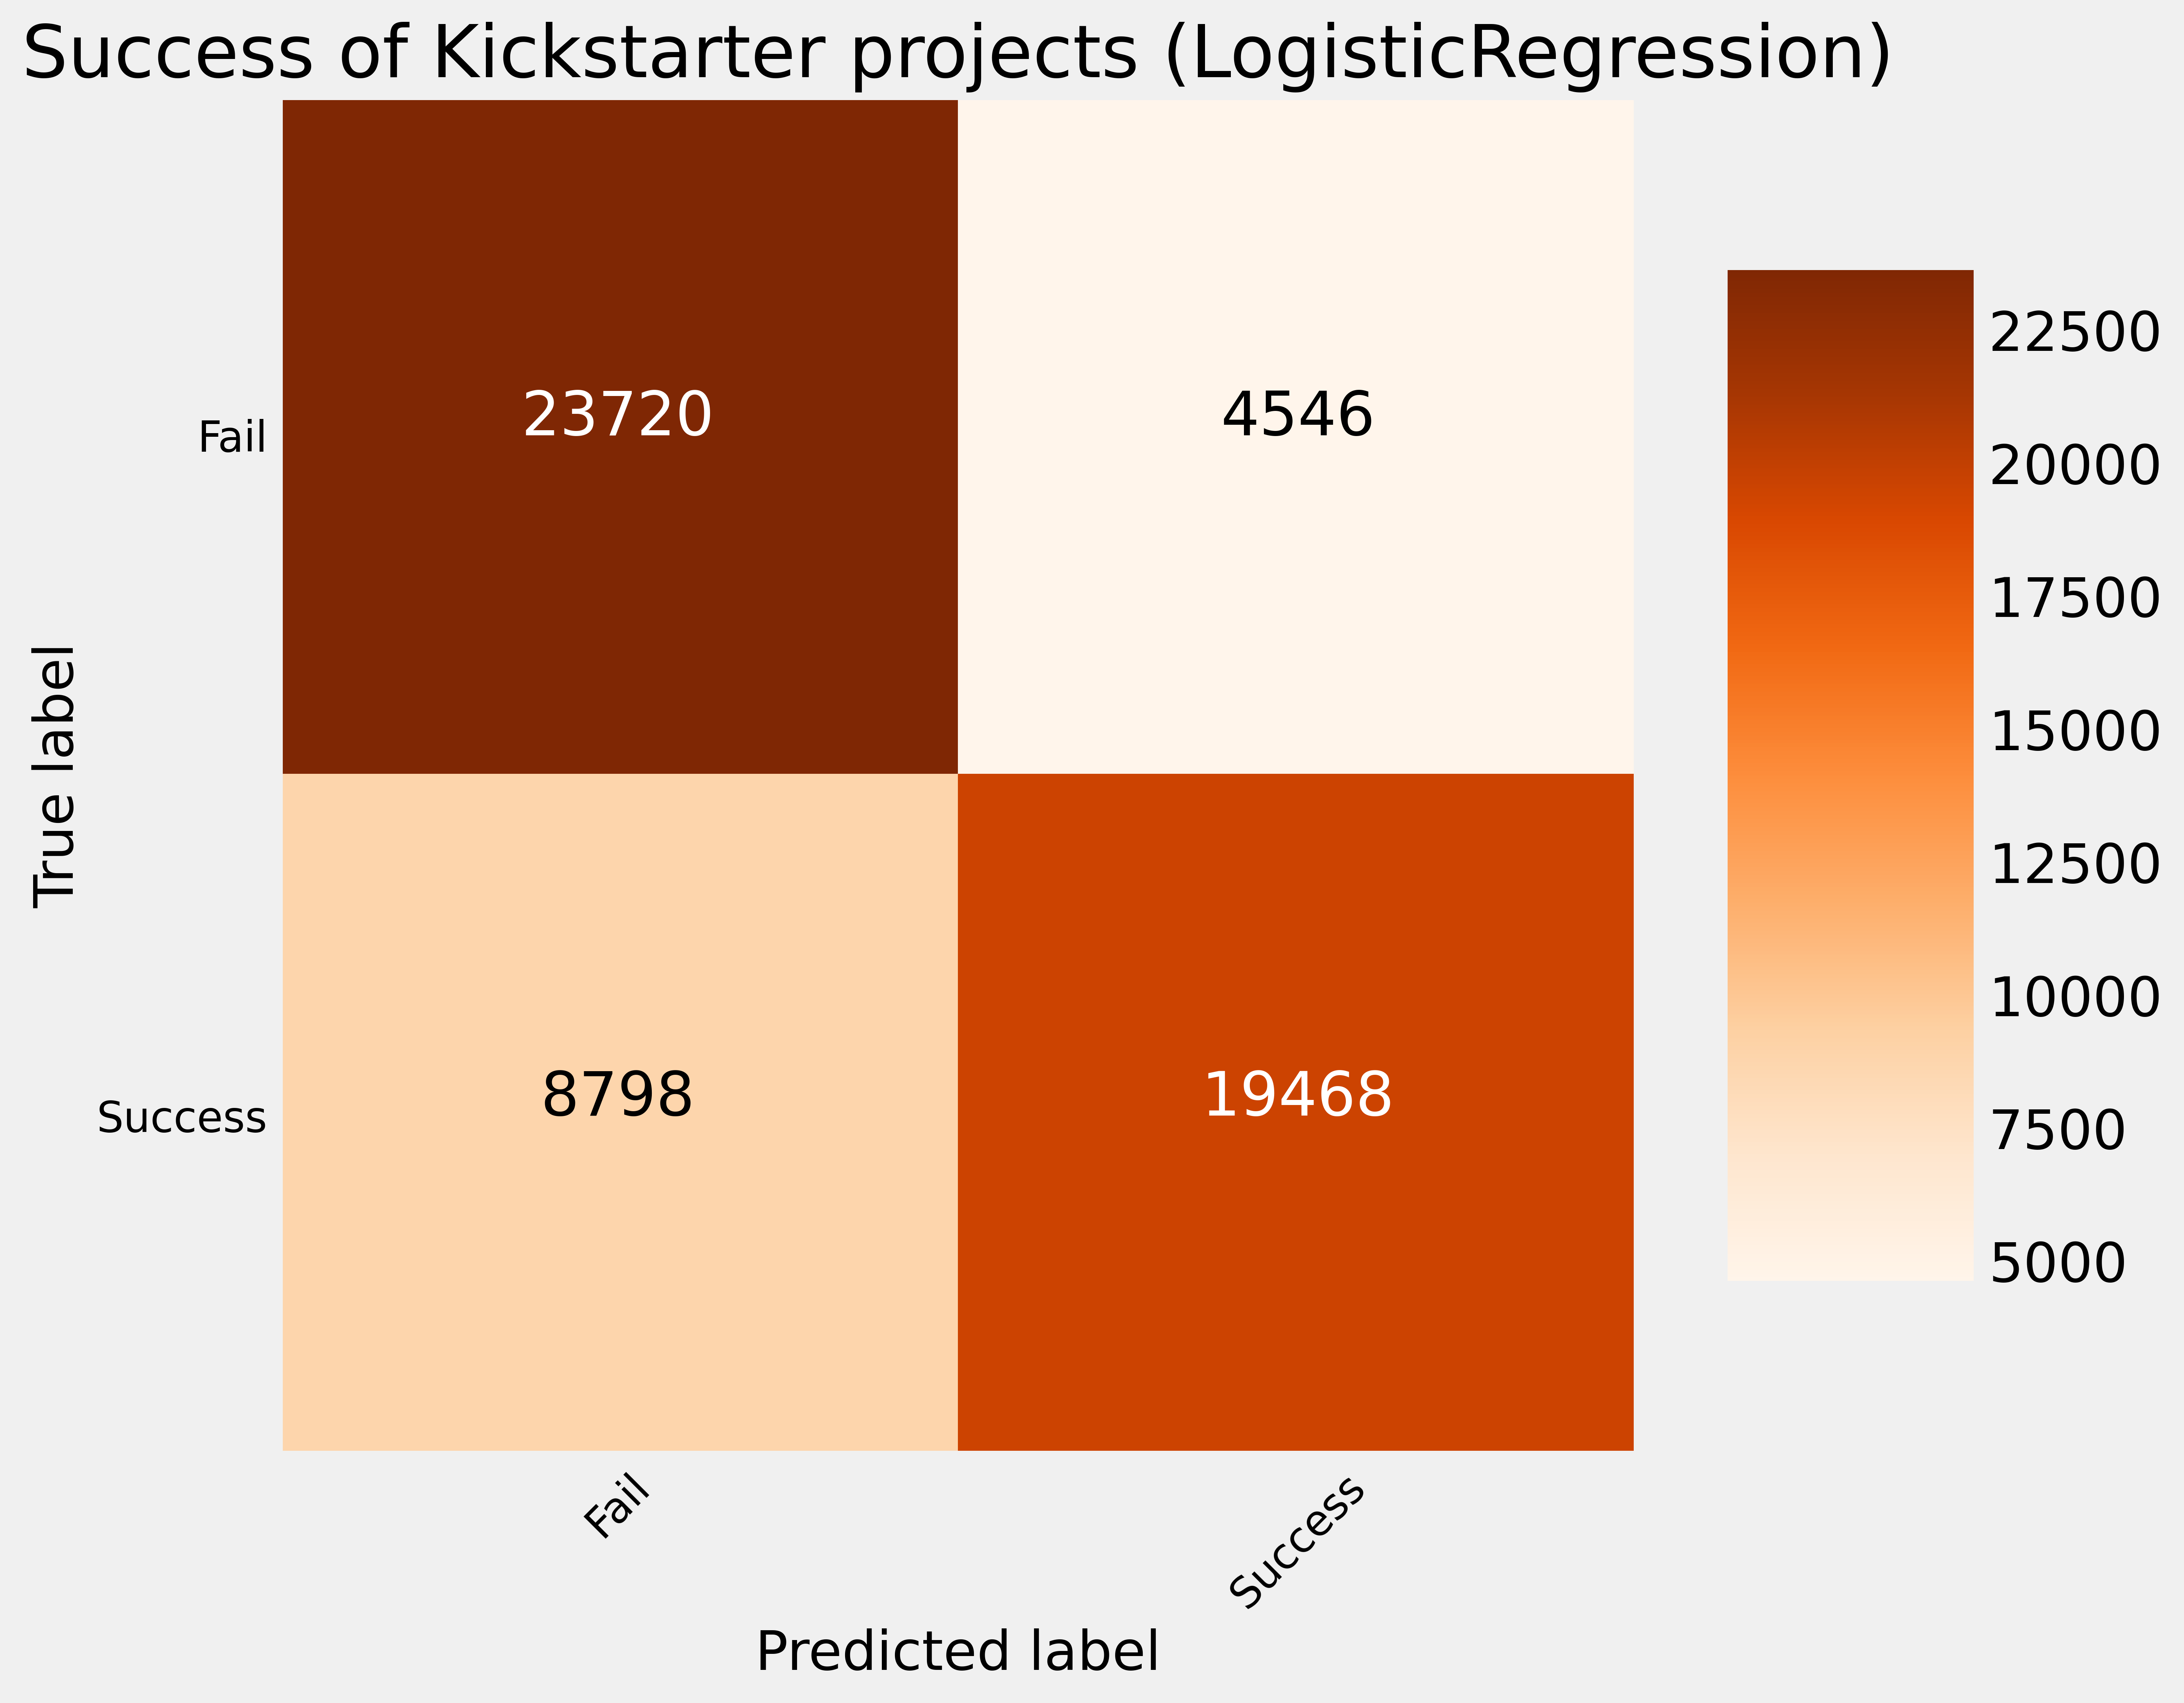

In [59]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=10000)
y_pred_lg = clf_train_predict(clf_lr, train, train_label, test)
cm = simple_metrics(test_label, y_pred_lg)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (LogisticRegression)'
)


Extra Trees

accuracy_score 0.81546734592797
f1-score 0.7947587943653106
Confusion matrix, without normalization
[[25902  2364]
 [ 8068 20198]]


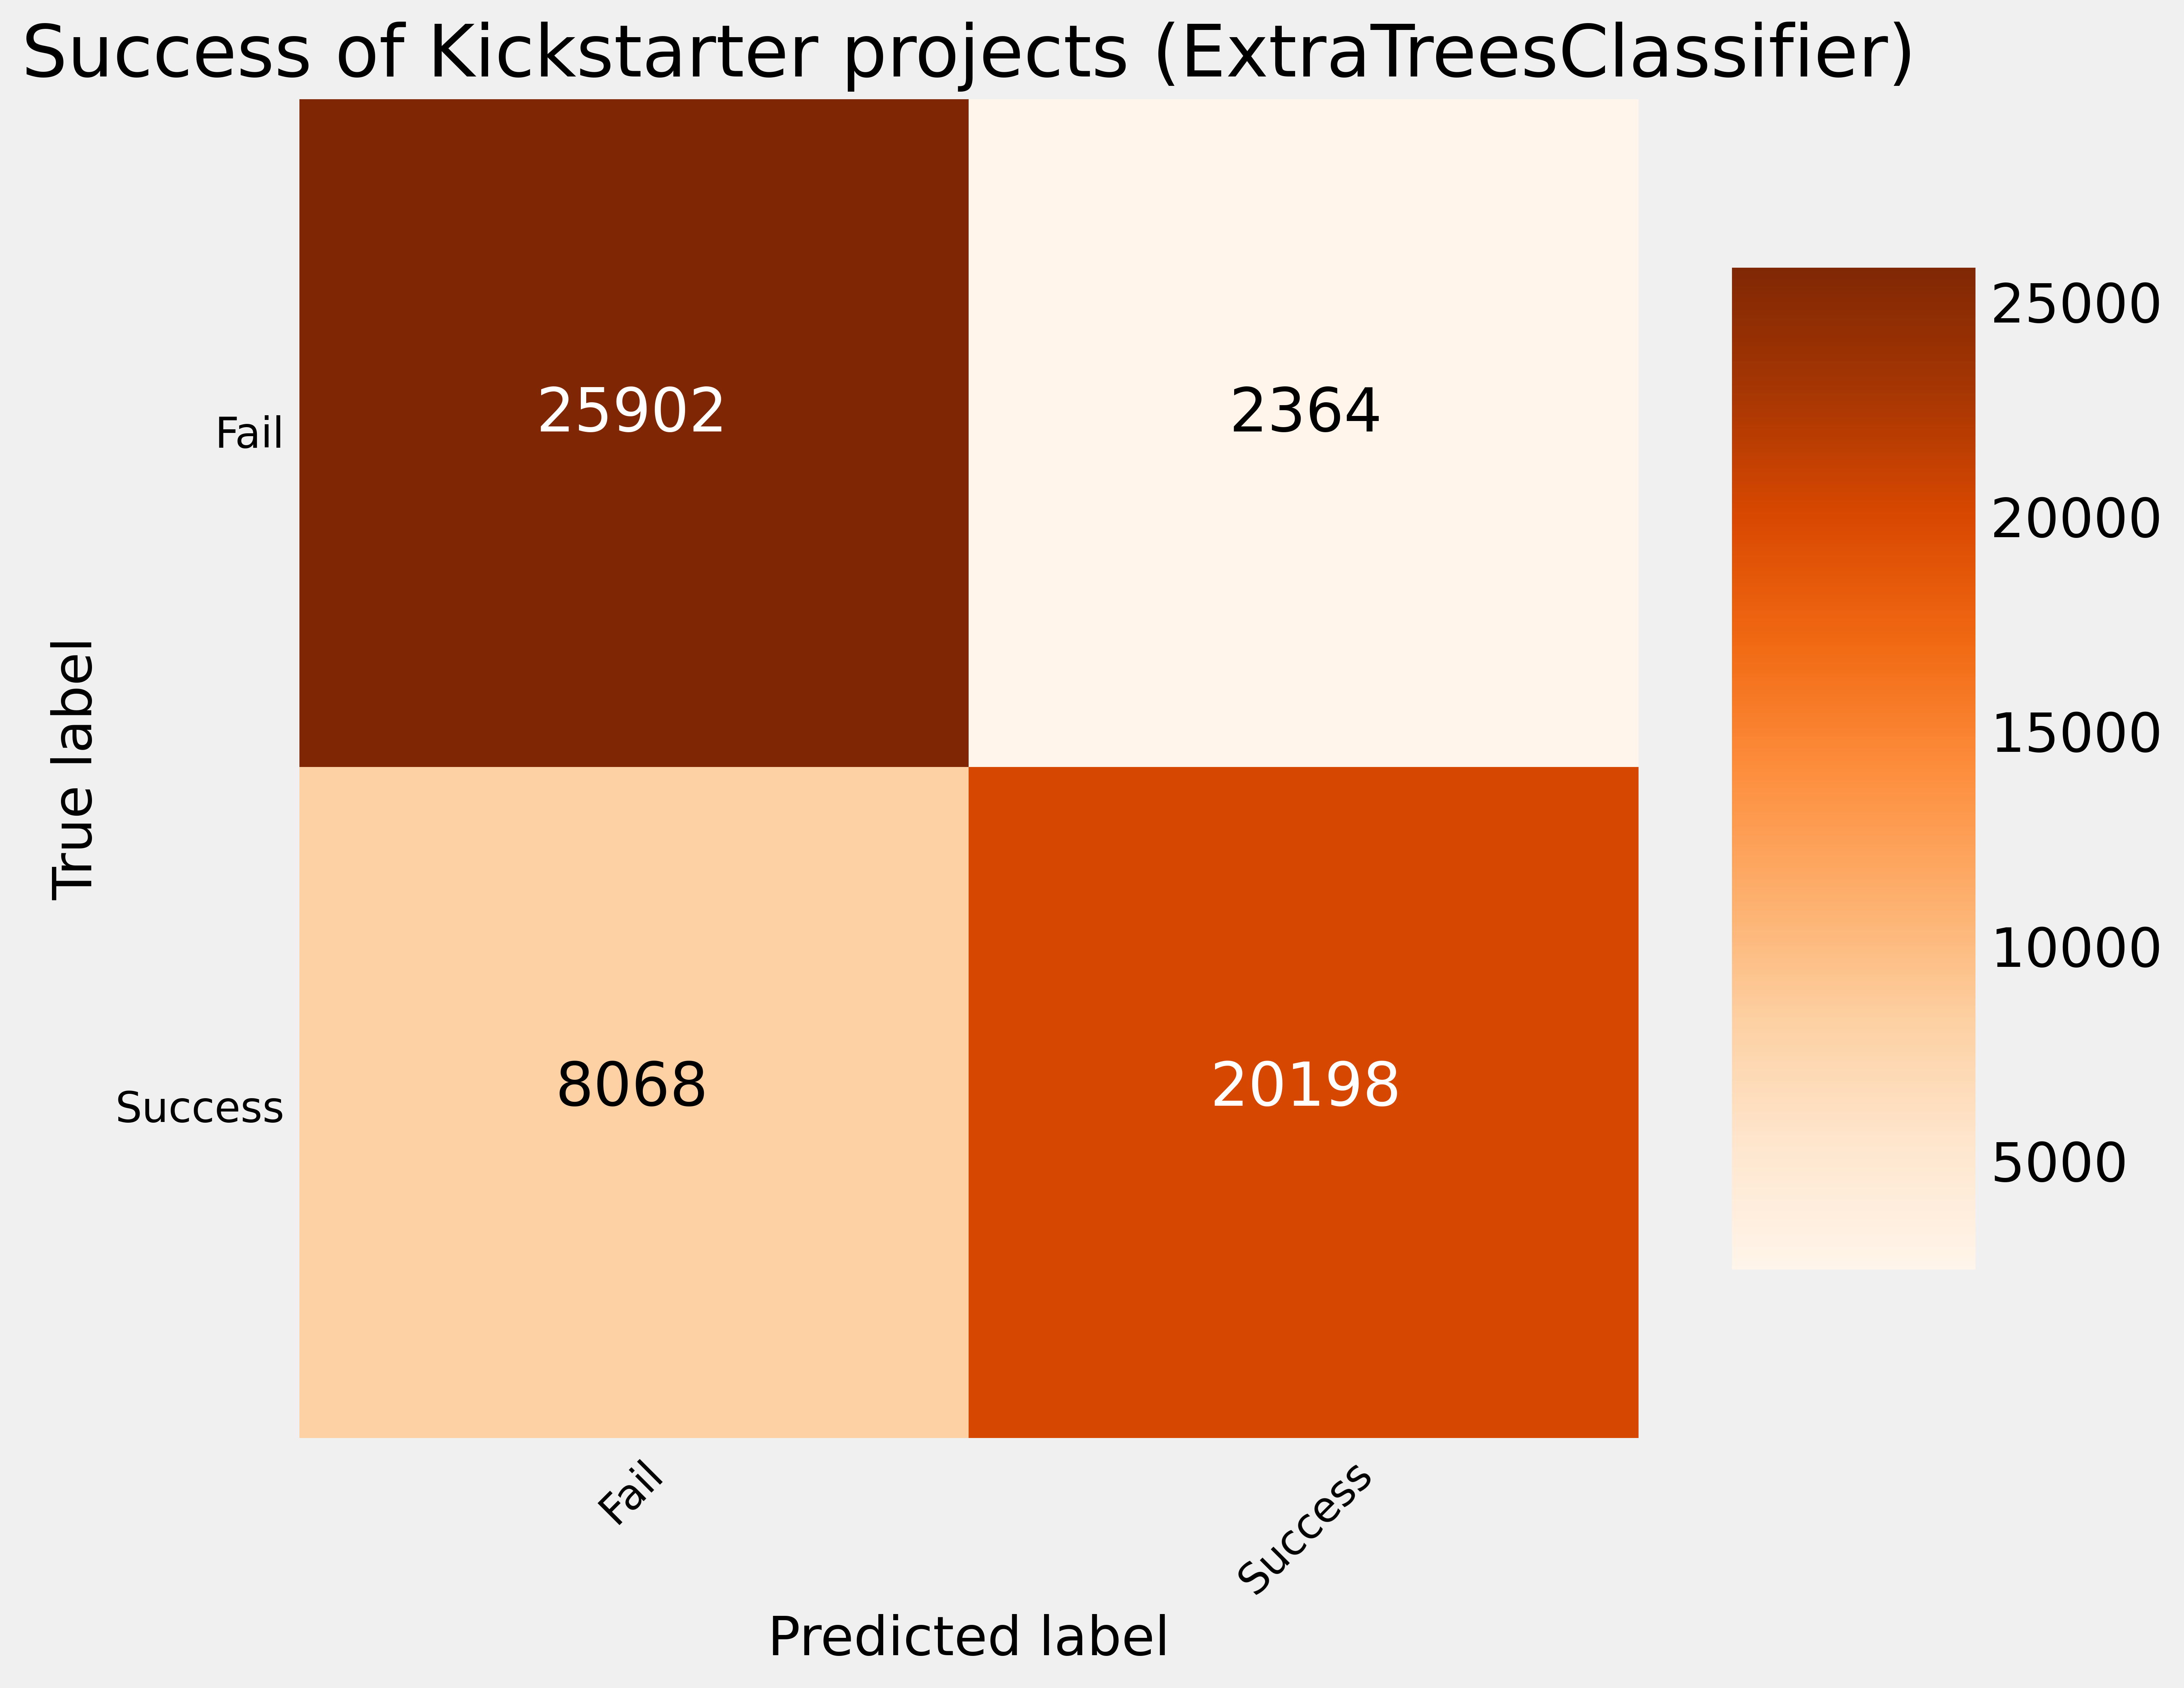

In [60]:
from sklearn.ensemble import ExtraTreesClassifier

clf_xt = ExtraTreesClassifier(n_estimators=200, n_jobs=-1)
y_pred_xt = clf_train_predict(clf_xt, train, train_label, test)
cm = simple_metrics(test_label, y_pred_xt)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (ExtraTreesClassifier)'
)

AdaBoost

accuracy_score 0.7630545531734239
f1-score 0.7435431065842125
Confusion matrix, without normalization
[[23719  4547]
 [ 8848 19418]]


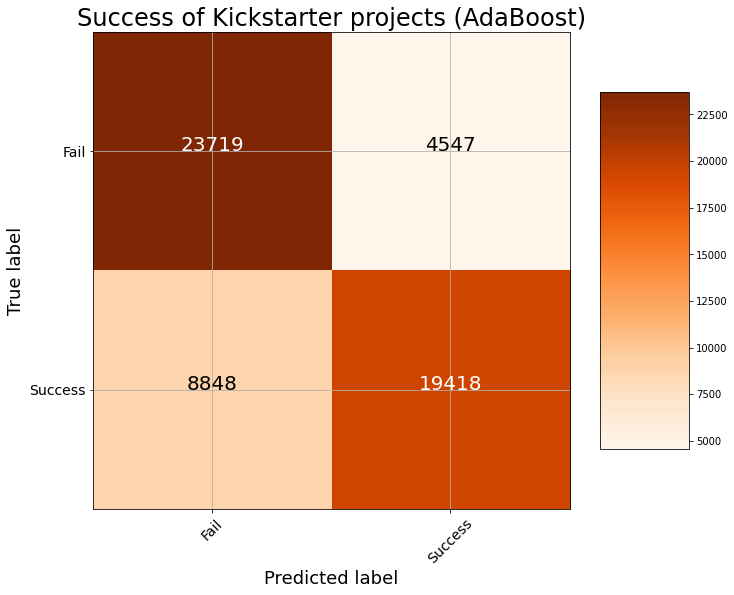

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_ab = AdaBoostClassifier()
y_pred_ab = clf_train_predict(clf_ab, train, train_label, test)
cm = simple_metrics(test_label, y_pred_ab)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (AdaBoost)'
)

## Gridsearch using Random Forests

n_estimators=100
max_depth=None
min_samples_leaf=1
min_impurity_decrease=0.0


In [61]:
param_grid = {'n_estimators':[5, 20, 100, 200], 'max_depth':[None, 10, 2], 
        'min_impurity_decrease':[0.0, 0.05, 0.5], 'max_features':['sqrt', None, 0.5]}

gs = RandomizedSearchCV(RandomForestClassifier(random_state=RSEED), param_grid, scoring='f1',
                  cv=5, verbose=1, n_jobs=-1, n_iter=10)

# Fit gridsearch object to data.. also lets see how long it takes

gs.fit(train, train_label)



In [ ]:
best_score = gs.best_score_
best_params = gs.best_params_
print (best_score)
print (best_params)

NameError: name 'gs' is not defined

Fitting 5 folds for each of 10 candidates, totalling 50 fits
accuracy_score 0.8008030849784193
f1-score 0.7790791203186
Confusion matrix, without normalization
[[25415  2851]
 [ 8410 19856]]


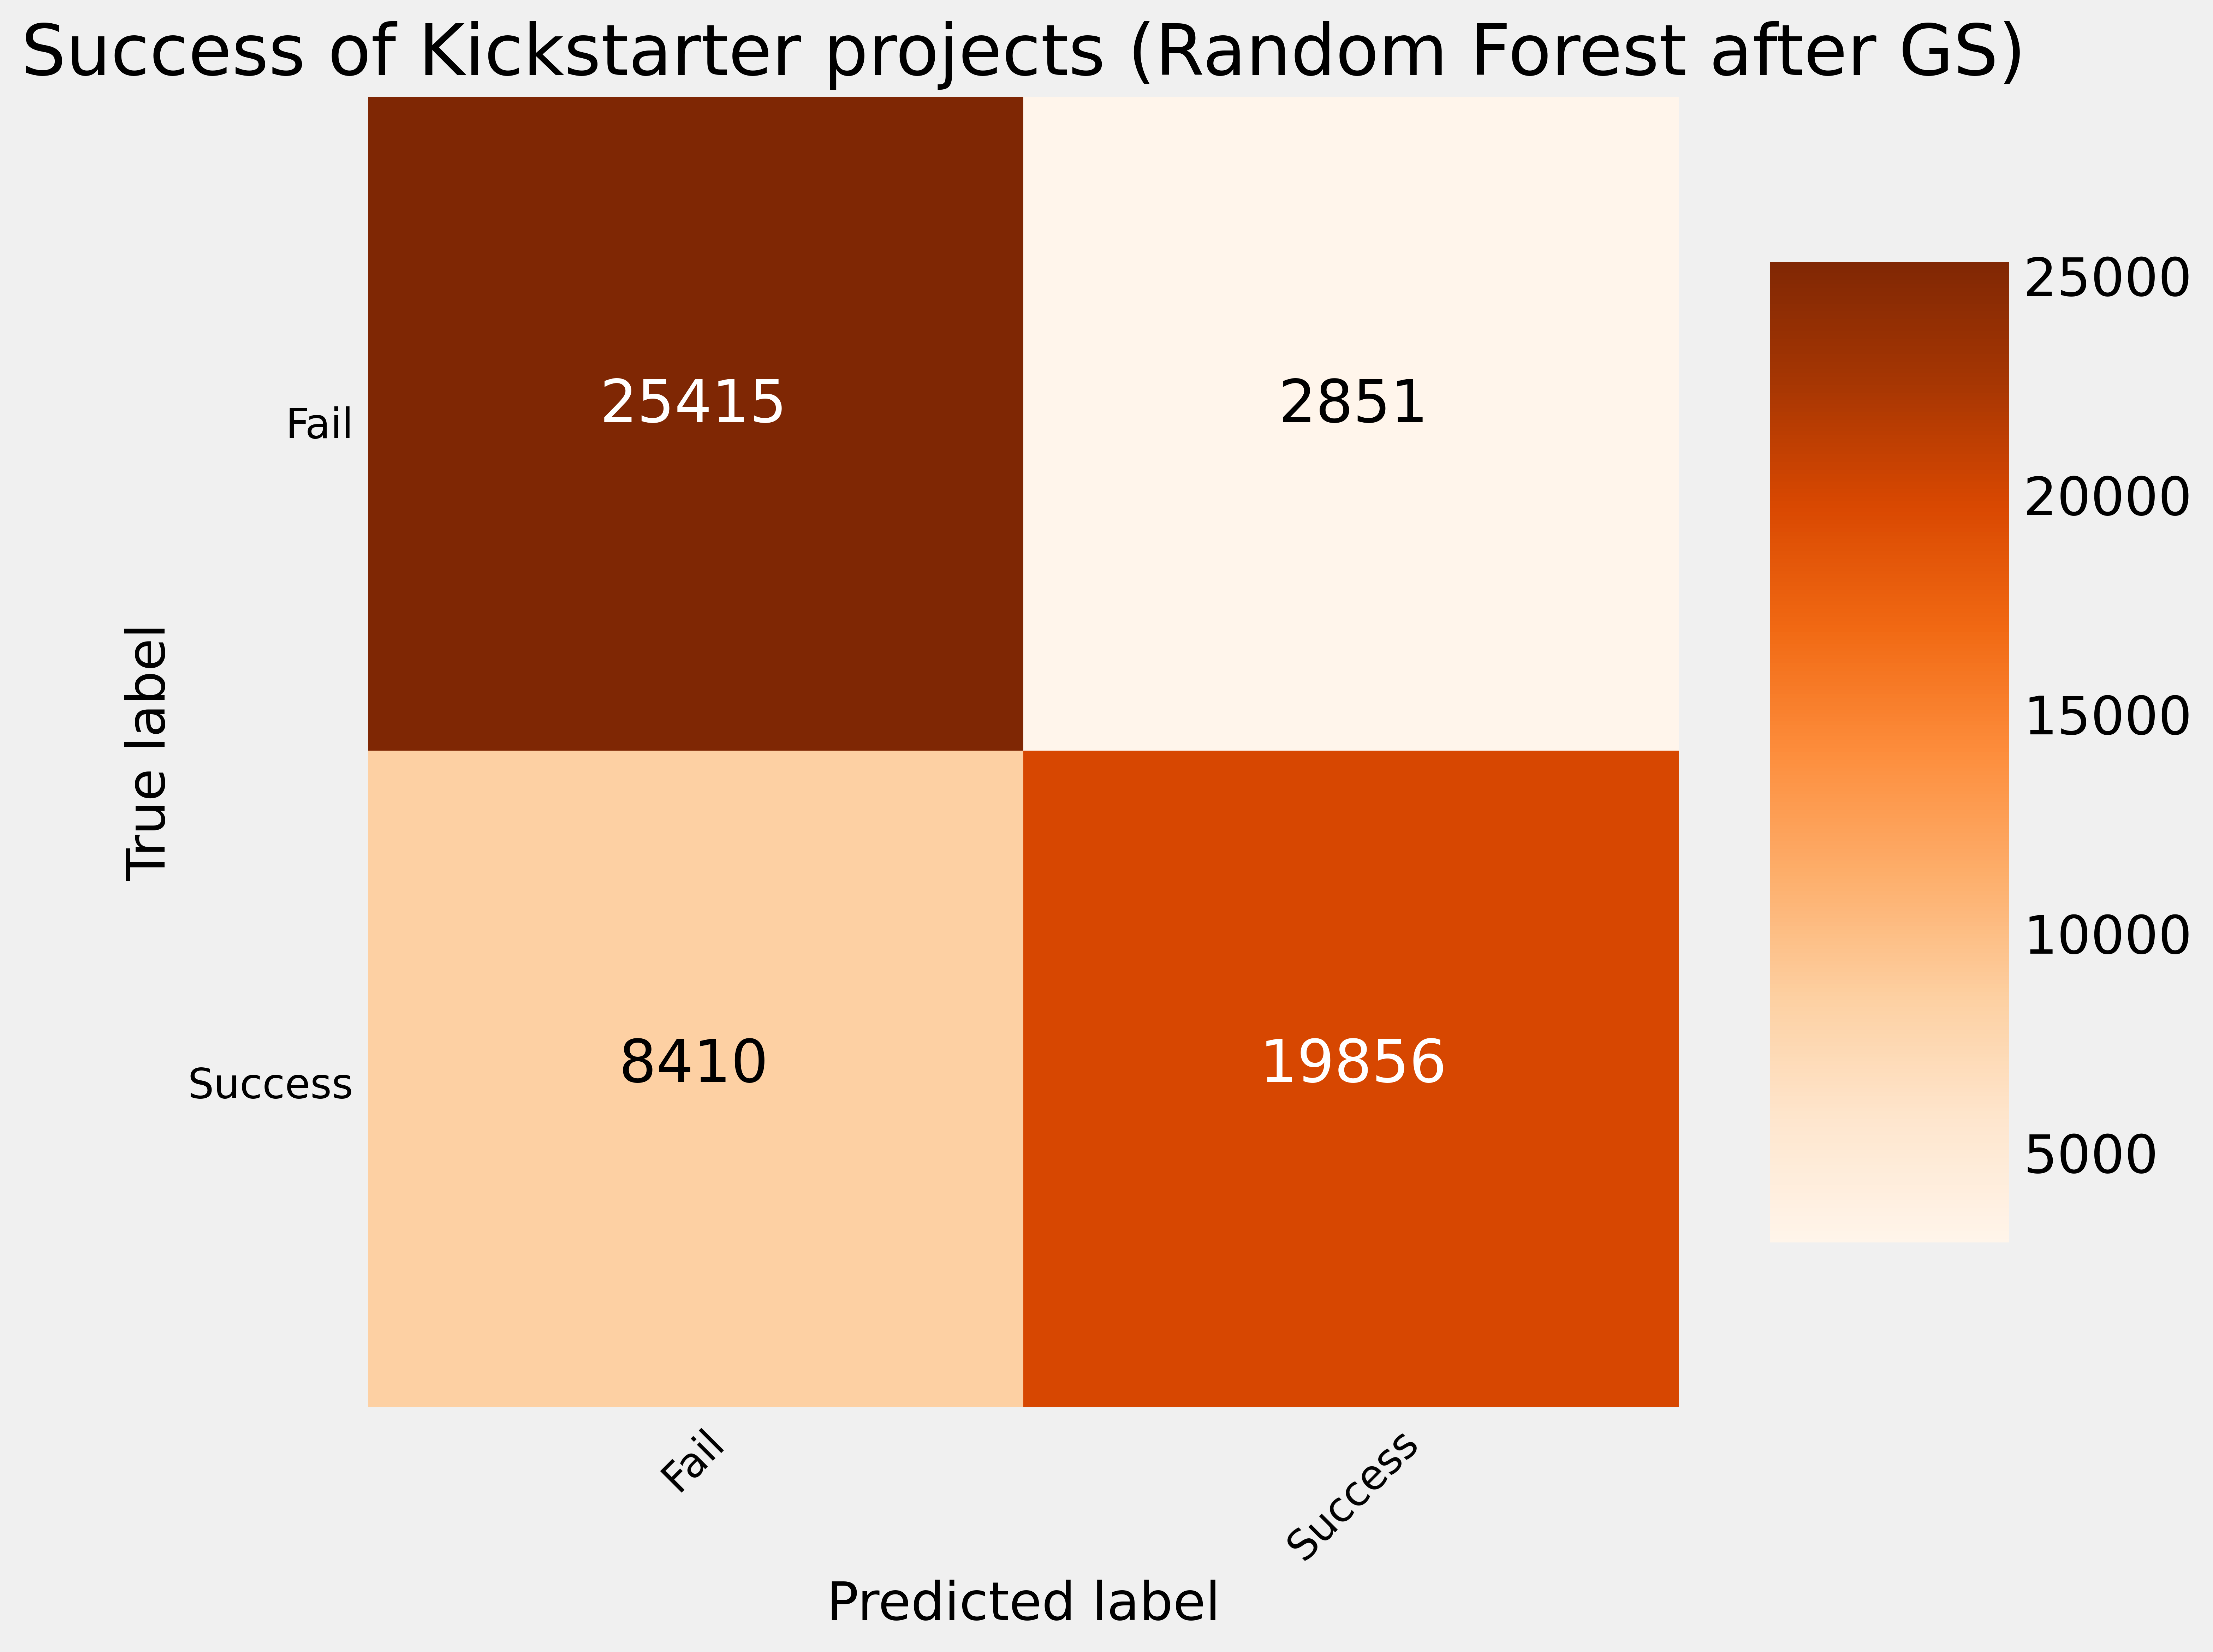

In [63]:
clf_rf_best = gs.best_estimator_

y_pred_rf_best = clf_rf_best.predict(test)
cm = simple_metrics(test_label, y_pred_rf_best)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest after GS)'
)


## Stacking

Random forest + logistic regression + XGBoost

accuracy_score 0.8311045071817732
f1-score 0.818244117871012
Confusion matrix, without normalization
[[25492  2774]
 [ 6774 21492]]


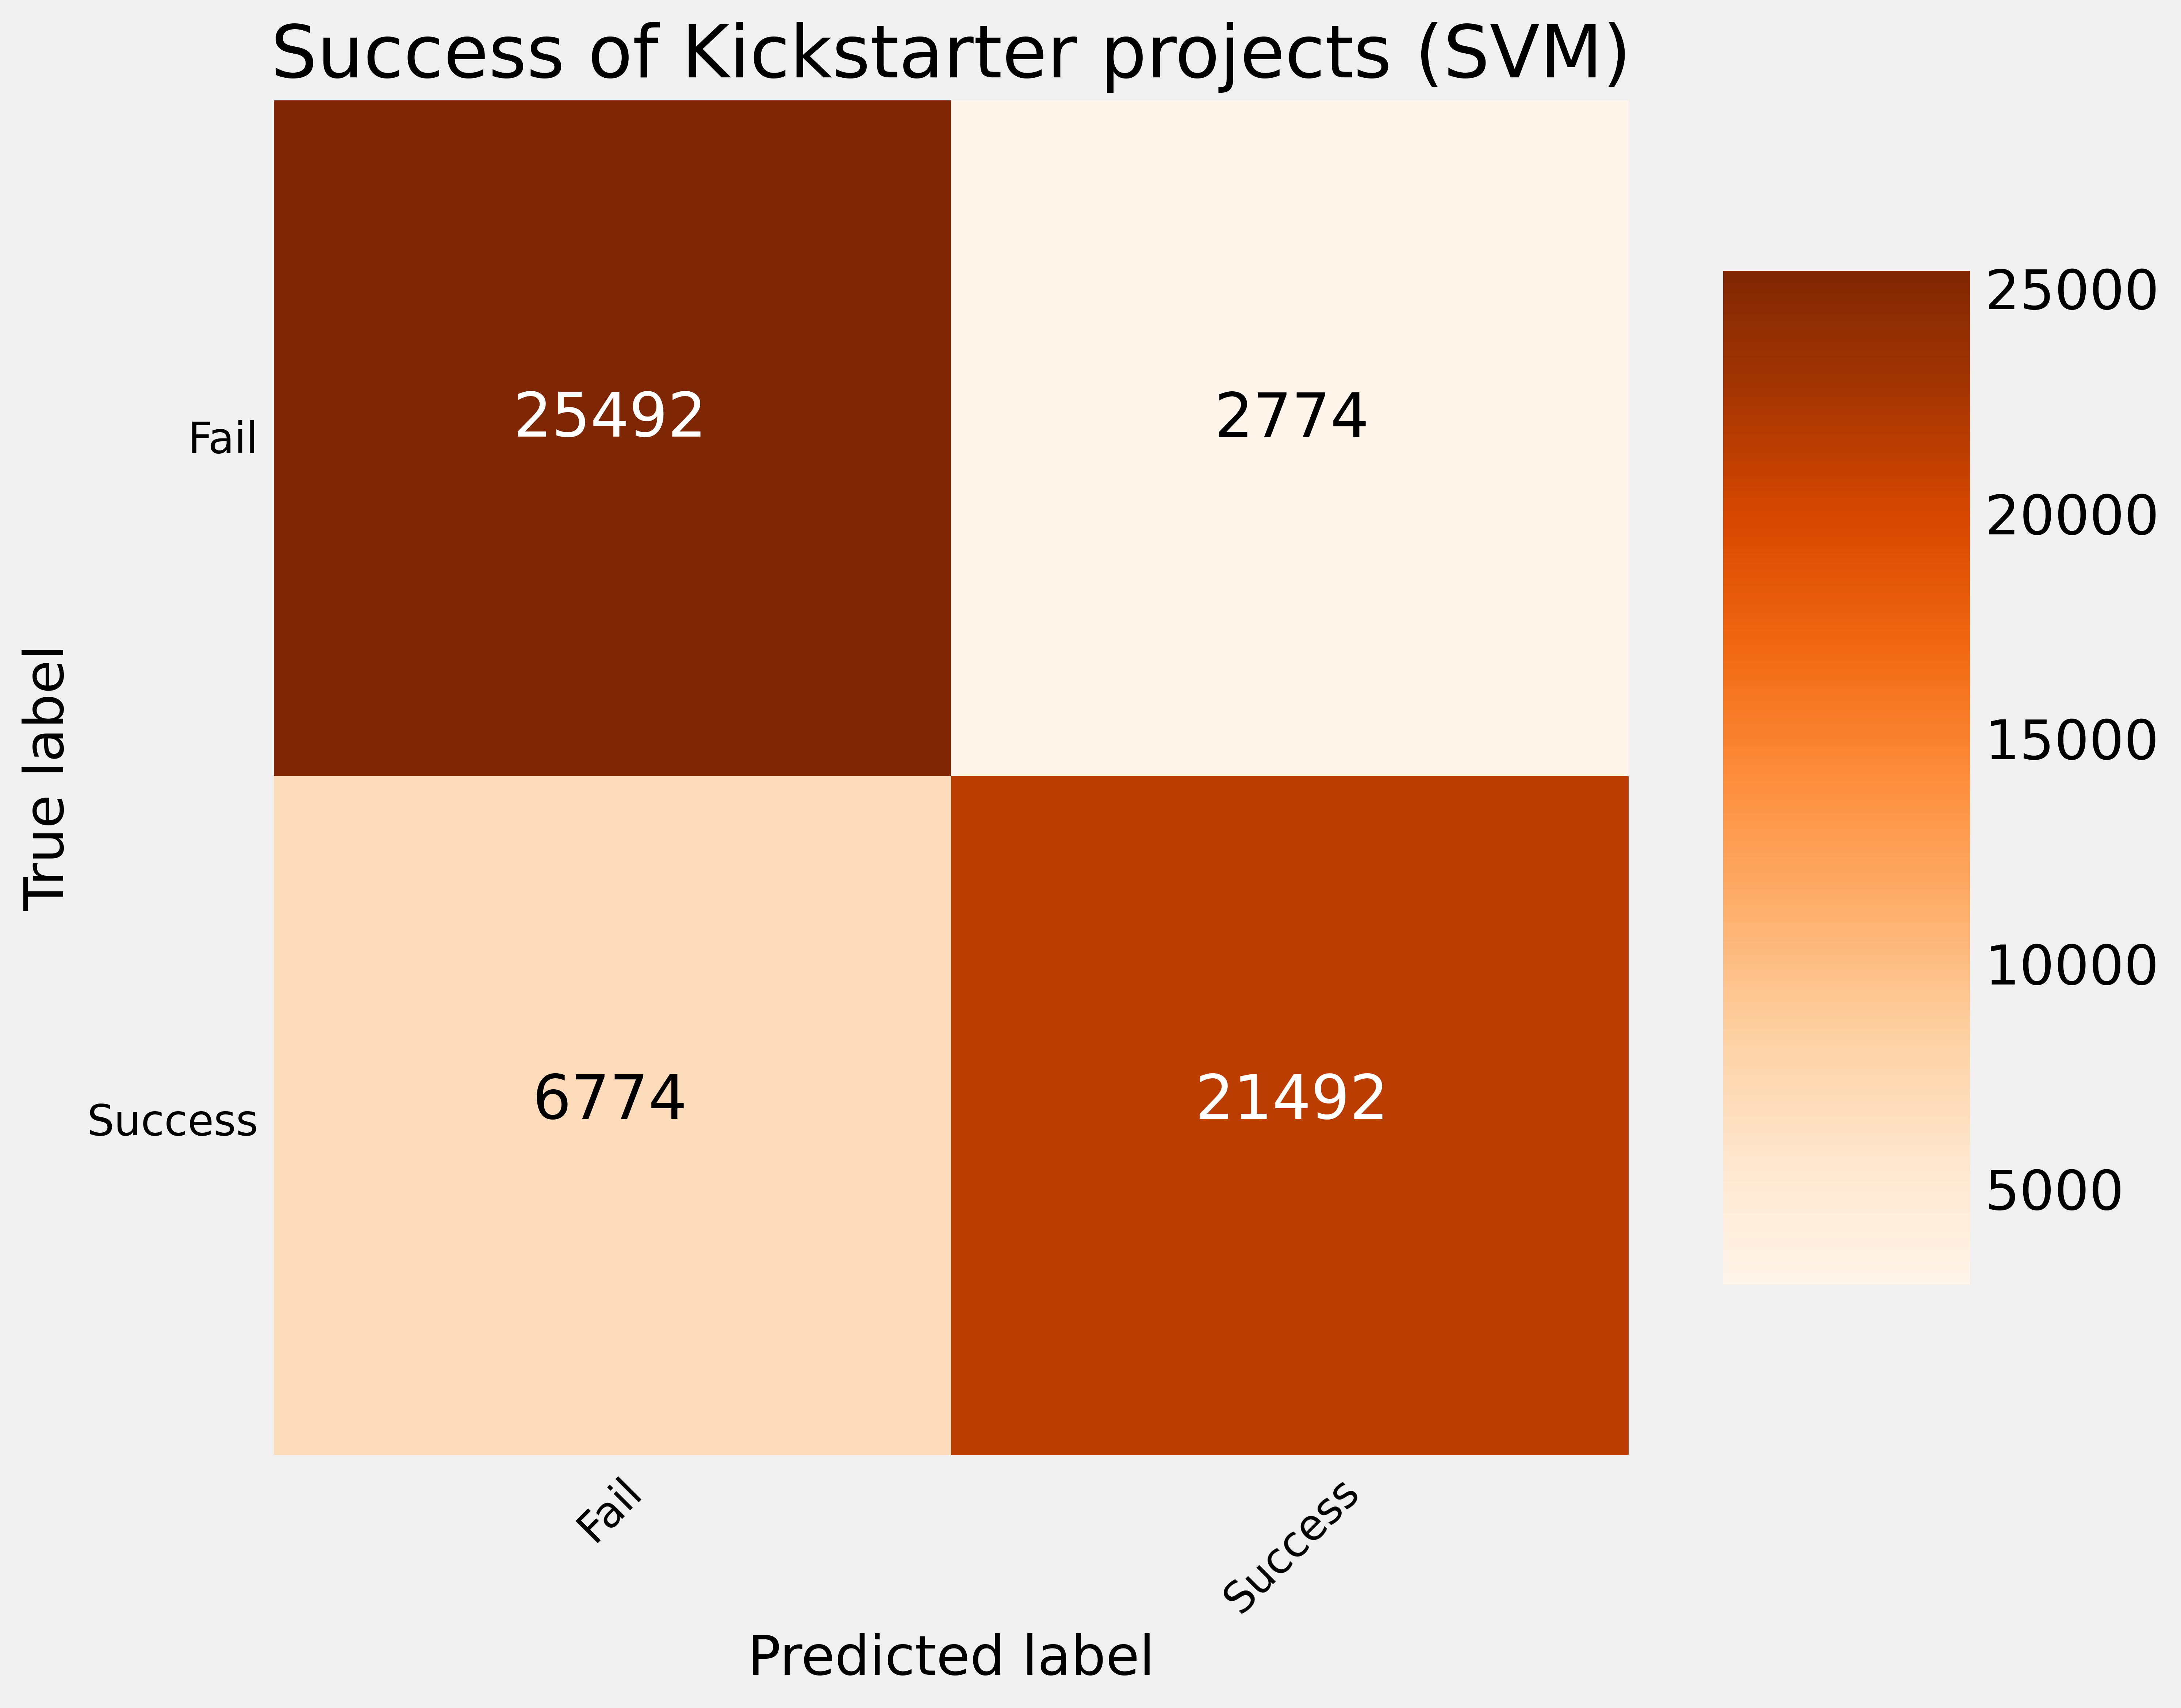

In [64]:
#clf_stacking = ??
# clf_stack = StackingClassifier([('Random_Forest', clf_rf),
# ('XGB',clf_xgb),
# ('Naive Bayes',clf_lr)], cv=5)
clf_stack = StackingClassifier([
    ('Random_Forest', clf_rf),
    ('Extreme Tree', clf_xt)], 
    cv=5, n_jobs=-1)
y_pred_stack = clf_train_predict(clf_stack, train, train_label, test)
cm = simple_metrics(test_label, y_pred_stack)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (SVM)'
)